In [1]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from sklearn.manifold import TSNE

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((28))])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 101912993.03it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 65942130.55it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24002510.64it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13048307.38it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
train_loader = DataLoader(train_dataset, batch_size=1000)
test_loader = DataLoader(test_dataset, batch_size=100)

In [4]:
train_data = []
test_data = []


class_count_train = [0] * 10
for images, labels in train_loader:
    for i in range(len(labels)):
        label = int(labels[i])
        if class_count_train[label] < 100:
          train_data.append((images[i].numpy().reshape((1, 1, 28, 28)), label))
          class_count_train[label] += 1

train_data = np.array(train_data, dtype=object)


class_count_test = [0] * 10
for images, labels in test_loader:
    for i in range(len(labels)):
        label = int(labels[i])
        if class_count_test[label] < 10:
          test_data.append((images[i].numpy().reshape((1, 1, 28, 28)), label))
          class_count_test[label] += 1

test_data = np.array(test_data, dtype=object)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)



Train data shape: (1000, 2)
Test data shape: (100, 2)


In [5]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1, padding=2)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride=1, padding=2)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc = nn.Sequential(
        nn.Linear(4 * 7 * 7, 49),
        nn.ReLU(),
        nn.Linear(49, 10),
    )

  def forward(self, x):

    x = F.relu(self.conv1(x))
    x = self.maxpool1(x)

    x = F.relu(self.conv2(x))
    x = self.maxpool2(x)

    x_flat = x.reshape(-1, 196)

    x_out = self.fc(x_flat)

    return x_out, x_flat

  def vis(self, x):
    slices = []
    x = self.conv1(x)
    slices.append(x)
    x = F.relu(x)
    x = self.maxpool1(x)
    x = F.relu(self.conv2(x))
    slices.append(x)
    return slices


In [6]:
network = Network()
network

Network(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Sequential(
    (0): Linear(in_features=196, out_features=49, bias=True)
    (1): ReLU()
    (2): Linear(in_features=49, out_features=10, bias=True)
  )
)

In [7]:
def shuffle(data):

  n = len(data)
  permutation = np.random.permutation(n)
  data = [(data[i][0], data[i][1]) for i in permutation]
  return data

In [10]:
def visualize_tsne(network, data, labels):
    network.eval()
    with torch.no_grad():
        logits = network(data)[0]
        probabilities = F.softmax(logits, dim=-1).detach().numpy()
        X_embedded = TSNE(n_components=2, perplexity=20, n_iter=5000).fit_transform(probabilities)

        sorted_indices = sorted(range(len(labels)), key=lambda k: labels[k])
        sorted_data = X_embedded[sorted_indices]
        sorted_labels = [labels[i] for i in sorted_indices]

        fig, ax = plt.subplots()
        for i in range(10):
            ax.scatter(sorted_data[10*i:10*i+10, 0], sorted_data[10*i:10*i+10, 1], label=f'{sorted_labels[10*i]}')
        ax.legend()
        plt.show()

In [28]:
def train(epochs, train_data, test_data, batch_size, method, tsne):

  if method == 'sgd':
    optimiser = optim.SGD(network.parameters(), lr=0.1)

  if method == 'momentum':
    optimiser = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)

  if method == 'rmsprop':
    optimiser = optim.RMSprop(network.parameters(), lr=0.001, alpha=0.9)

  loss_f = nn.CrossEntropyLoss()
  train_errors = []
  test_errors = []
  bottlenecks = []

  for epoch in range(epochs):
    print(f'Epoch:{epoch+1}/{epochs}')
    train_data = shuffle(train_data)

    train_error = 0
    test_error = 0
    correct_train = 0
    correct_test = 0

    network.train()
    for start_idx in range(0, len(train_data), batch_size):
      end_idx = start_idx + batch_size if start_idx + batch_size <= len(train_data) else len(train_data)

      batch = train_data[start_idx:end_idx]
      inputs = torch.stack([torch.from_numpy(item[0]).squeeze(0) for item in batch])
      targets = torch.tensor([item[1] for item in batch])

      optimiser.zero_grad()
      outputs = network(inputs)[0]
      loss = loss_f(outputs, targets)
      loss.backward()
      optimiser.step()

      train_error += loss.item()

      correct_train += torch.sum(torch.argmax(outputs, dim=1) == targets).item()

    network.eval()
    with torch.no_grad():
      for start_idx in range(0, len(test_data), batch_size):
        end_idx = start_idx + batch_size if start_idx + batch_size <= len(train_data) else len(train_data)

        batch = test_data[start_idx:end_idx]
        inputs = torch.stack([torch.from_numpy(item[0]).squeeze(0) for item in batch])
        targets = torch.tensor([item[1] for item in batch])

        outputs = network(inputs)[0]
        loss = loss_f(outputs, targets)

        test_error += loss.item()

        correct_test += torch.sum(torch.argmax(outputs, dim=1) == targets).item()

    train_errors.append(train_error / len(train_data))
    test_errors.append(test_error / len(test_data))

    train_accuracy = correct_train / len(train_data) * 100
    test_accuracy = correct_test / len(test_data) * 100

    print(f'Train error: {train_errors[-1]}')
    print(f'Train accuracy: {train_accuracy}%')
    print(f'Test error: {test_errors[-1]}')
    print(f'Test accuracy: {test_accuracy}%')


    image = train_data[0][0]
    input_data = torch.from_numpy(image)
    activations = network.vis(input_data)
    fig, ax = plt.subplots(2, 4, figsize=(12, 3))

    for i in range(2):
      for j in range(4):
        activation_map = activations[i][:, j, :, :].detach().numpy()
        if i == 1:
            activation_map = activation_map.reshape(14, 14)
        else:
            activation_map = activation_map.reshape(28, 28)

        ax[i, j].imshow(activation_map, cmap='gray')
        ax[i, j].axis('off')

    plt.show()

    if tsne == True:
      if epoch == 0 or epoch == epochs-1:
        visualize_tsne(network, torch.stack([torch.from_numpy(item[0]).squeeze(0) for item in test_data]), [item[1] for item in test_data])

  N = np.arange(1, epochs+1)
  plt.title('Errors vs Epoch')
  plt.plot(N, train_errors, label='Train error')
  plt.plot(N, test_errors, label='Test error')
  plt.xlabel('Epochs')
  plt.ylabel('Error')
  plt.legend()
  plt.show()


I have used learning rate 0.1 for Vanilla SGD, 0.01 for Momentum and RMSProp for better convergence; can be changed to 0.001 in the above train function if needed.

Batch size = 50, Epochs = 15

Epoch:1/15
Train error: 0.046056635618209836
Train accuracy: 10.2%
Test error: 0.04597346067428589
Test accuracy: 11.0%


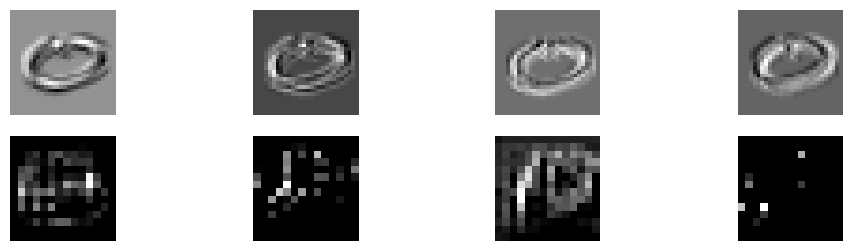

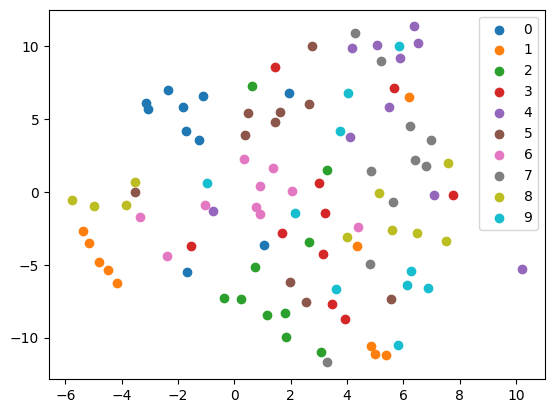

Epoch:2/15
Train error: 0.04582480812072754
Train accuracy: 17.8%
Test error: 0.045612566471099854
Test accuracy: 21.0%


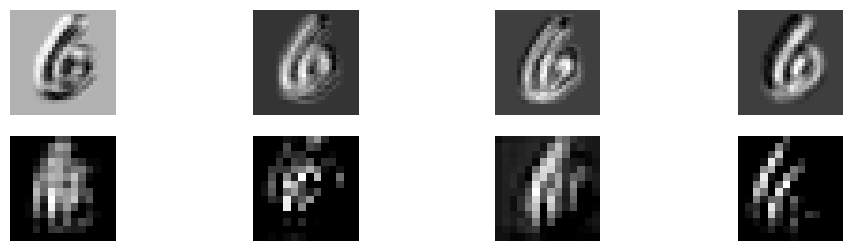

Epoch:3/15
Train error: 0.04485039281845093
Train accuracy: 26.0%
Test error: 0.043443670272827146
Test accuracy: 21.0%


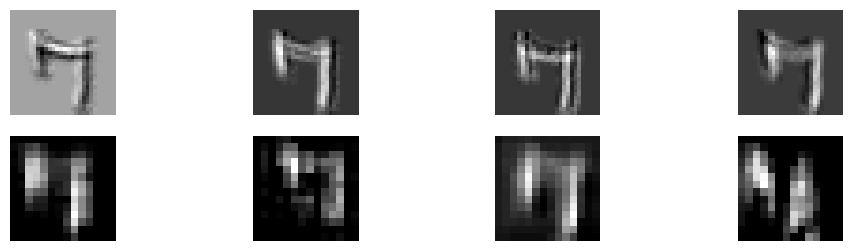

Epoch:4/15
Train error: 0.03753928625583649
Train accuracy: 38.3%
Test error: 0.031195064783096315
Test accuracy: 41.0%


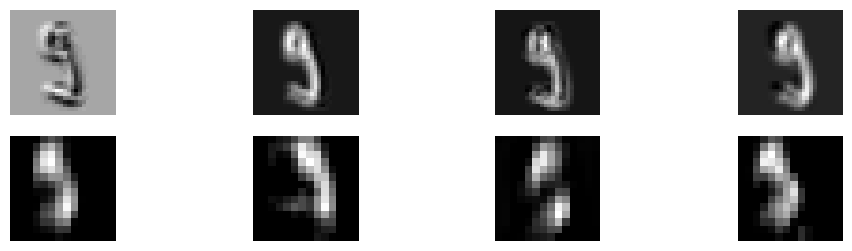

Epoch:5/15
Train error: 0.024917381525039674
Train accuracy: 56.99999999999999%
Test error: 0.01979028105735779
Test accuracy: 69.0%


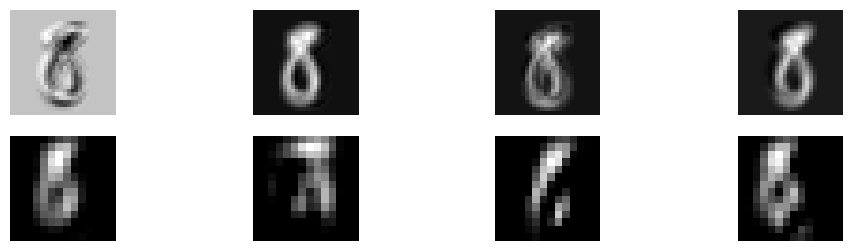

Epoch:6/15
Train error: 0.016675255477428437
Train accuracy: 74.1%
Test error: 0.014637542366981506
Test accuracy: 78.0%


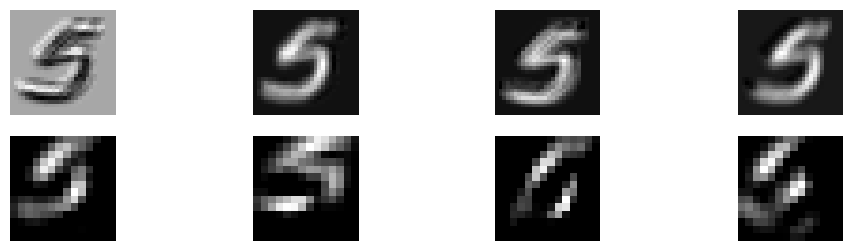

Epoch:7/15
Train error: 0.0122536239027977
Train accuracy: 79.9%
Test error: 0.015159064531326294
Test accuracy: 72.0%


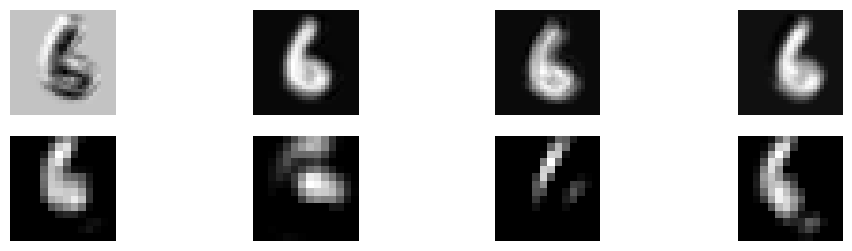

Epoch:8/15
Train error: 0.010575224667787552
Train accuracy: 82.5%
Test error: 0.010088068246841431
Test accuracy: 82.0%


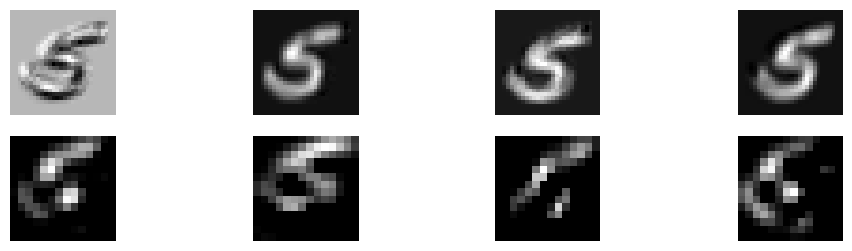

Epoch:9/15
Train error: 0.00820931127667427
Train accuracy: 87.5%
Test error: 0.007922837138175964
Test accuracy: 85.0%


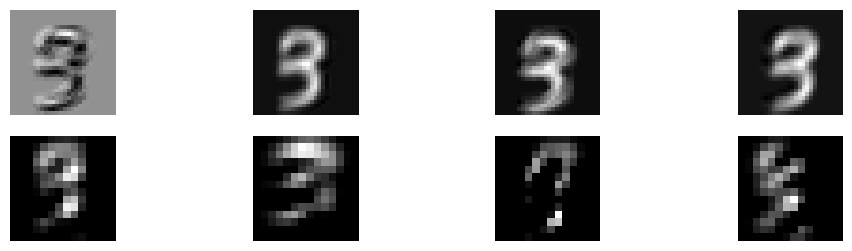

Epoch:10/15
Train error: 0.00753416034579277
Train accuracy: 88.4%
Test error: 0.007586531639099121
Test accuracy: 85.0%


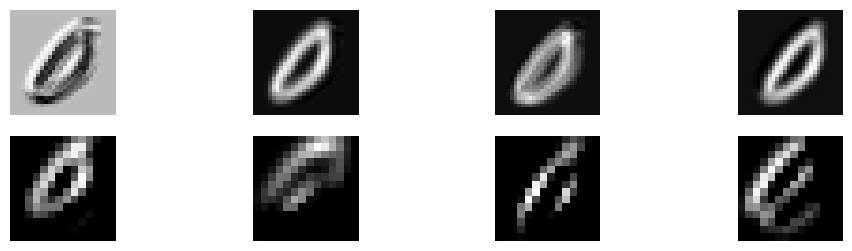

Epoch:11/15
Train error: 0.005772577784955502
Train accuracy: 90.5%
Test error: 0.004815546125173569
Test accuracy: 92.0%


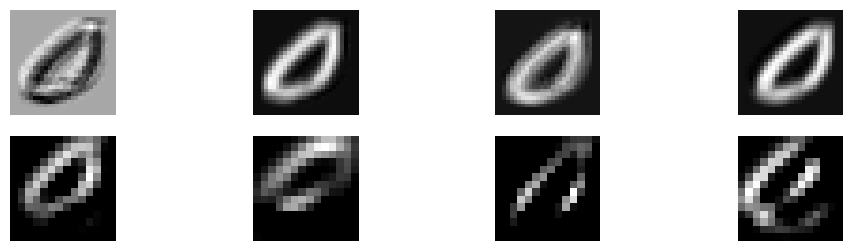

Epoch:12/15
Train error: 0.0044623114168643955
Train accuracy: 93.4%
Test error: 0.0056206294894218444
Test accuracy: 92.0%


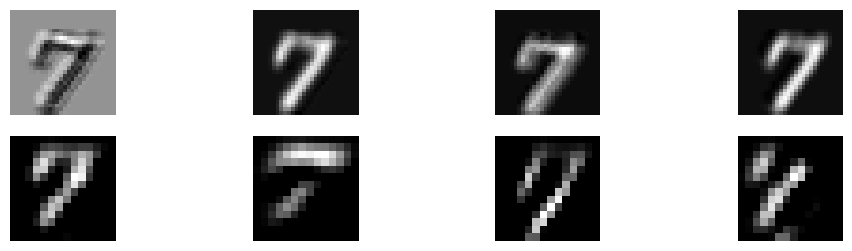

Epoch:13/15
Train error: 0.004988964863121509
Train accuracy: 92.60000000000001%
Test error: 0.004519042372703552
Test accuracy: 91.0%


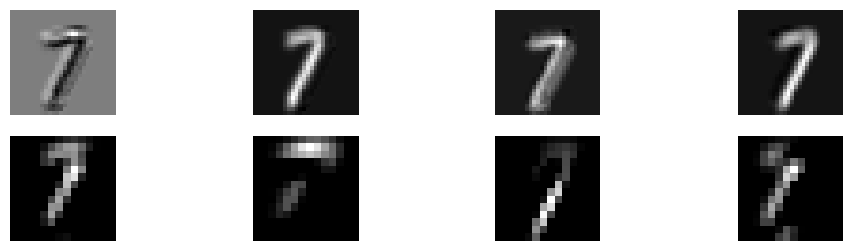

Epoch:14/15
Train error: 0.003372394174337387
Train accuracy: 94.6%
Test error: 0.004208280146121979
Test accuracy: 91.0%


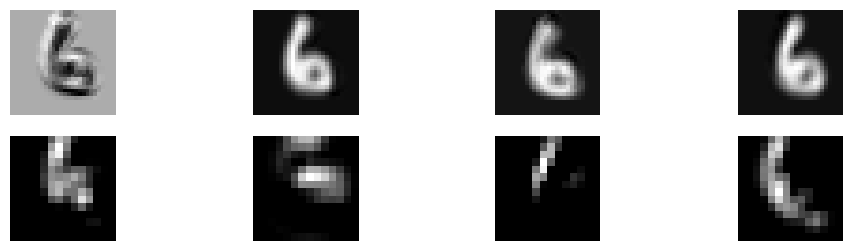

Epoch:15/15
Train error: 0.002852284125983715
Train accuracy: 95.8%
Test error: 0.005520198047161102
Test accuracy: 87.0%


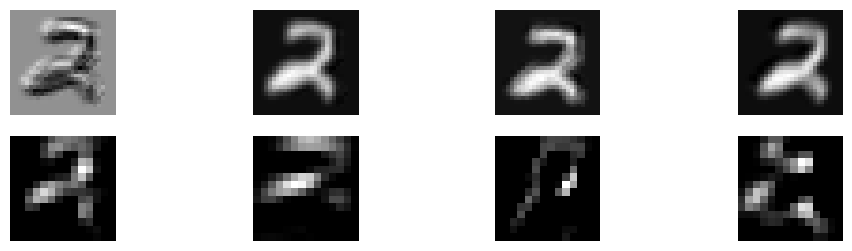

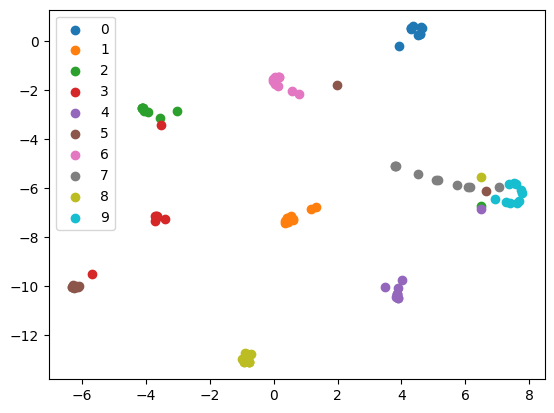

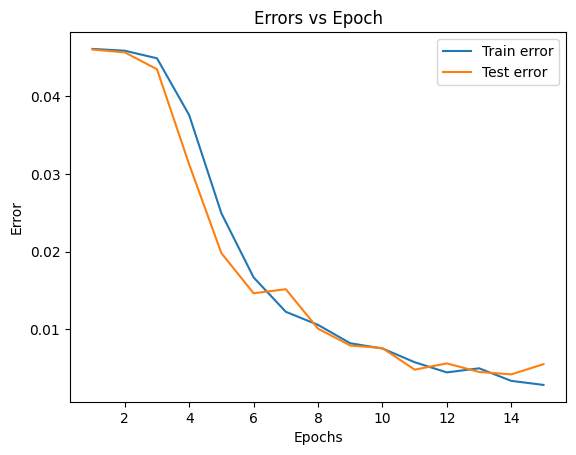

In [21]:
network = Network()
train(15, train_data, test_data, 50, 'sgd', True)

Epoch:1/15
Train error: 0.046072575569152834
Train accuracy: 11.3%
Test error: 0.04598139762878418
Test accuracy: 18.0%


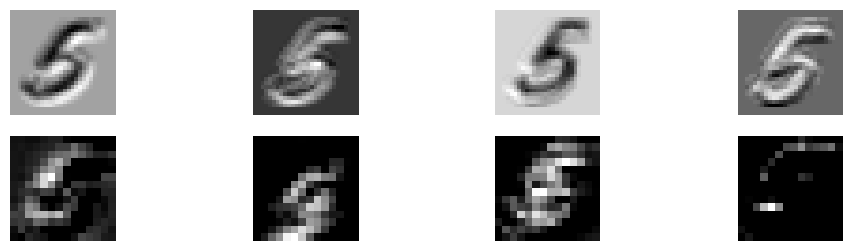

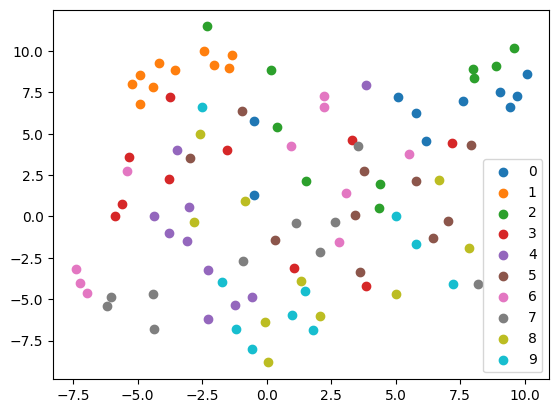

Epoch:2/15
Train error: 0.04578369426727295
Train accuracy: 19.7%
Test error: 0.04559814214706421
Test accuracy: 26.0%


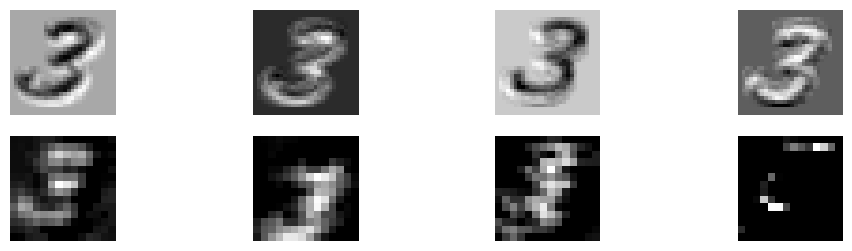

Epoch:3/15
Train error: 0.044990941286087036
Train accuracy: 33.1%
Test error: 0.044089856147766116
Test accuracy: 37.0%


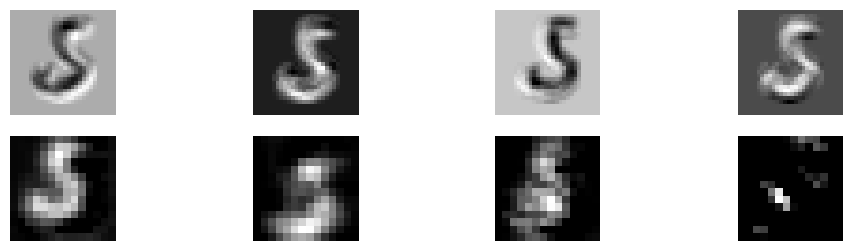

Epoch:4/15
Train error: 0.039973267912864686
Train accuracy: 42.6%
Test error: 0.031046674251556397
Test accuracy: 69.0%


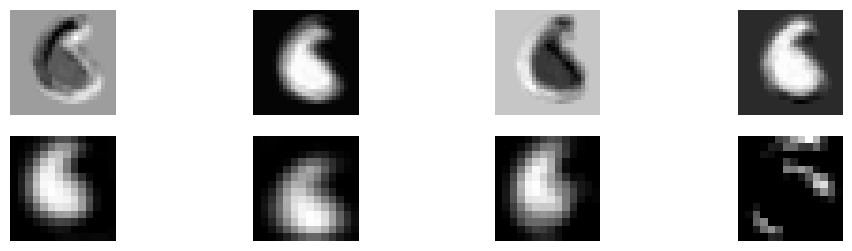

Epoch:5/15
Train error: 0.022244871258735657
Train accuracy: 67.10000000000001%
Test error: 0.018428510427474974
Test accuracy: 64.0%


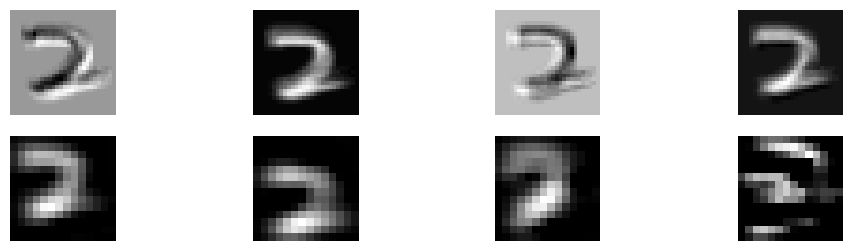

Epoch:6/15
Train error: 0.015069556564092637
Train accuracy: 75.2%
Test error: 0.011915839314460754
Test accuracy: 81.0%


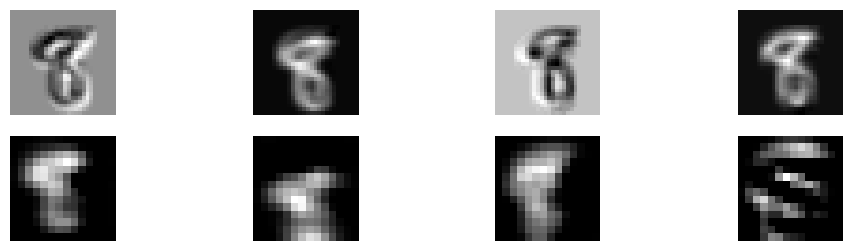

Epoch:7/15
Train error: 0.011552626848220825
Train accuracy: 82.89999999999999%
Test error: 0.0084733784198761
Test accuracy: 91.0%


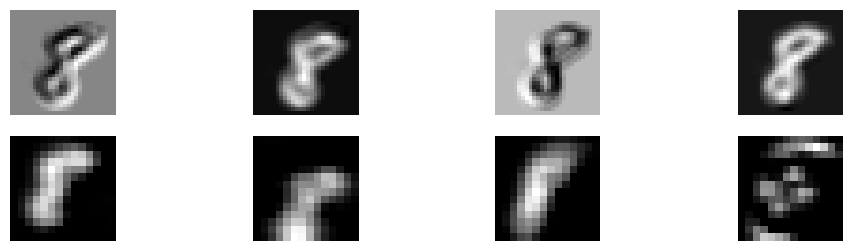

Epoch:8/15
Train error: 0.009429794475436211
Train accuracy: 87.0%
Test error: 0.0082119682431221
Test accuracy: 83.0%


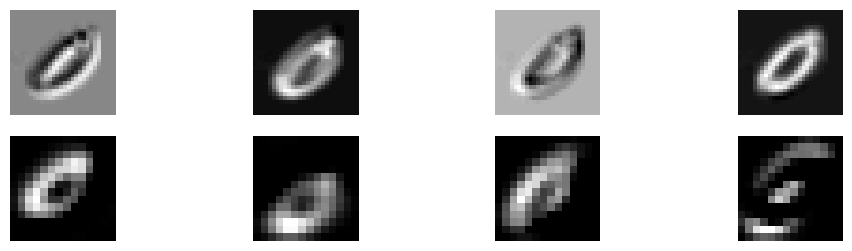

Epoch:9/15
Train error: 0.008046070769429207
Train accuracy: 87.1%
Test error: 0.008146537840366364
Test accuracy: 83.0%


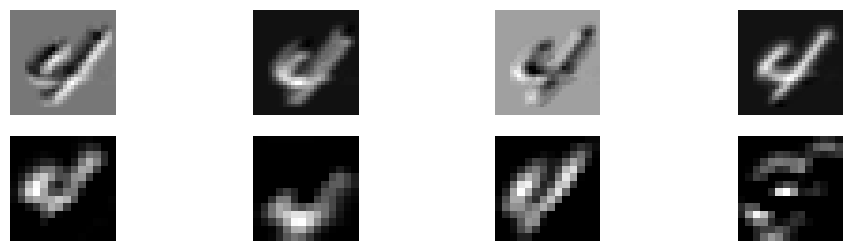

Epoch:10/15
Train error: 0.007672119155526161
Train accuracy: 88.3%
Test error: 0.005963487029075623
Test accuracy: 90.0%


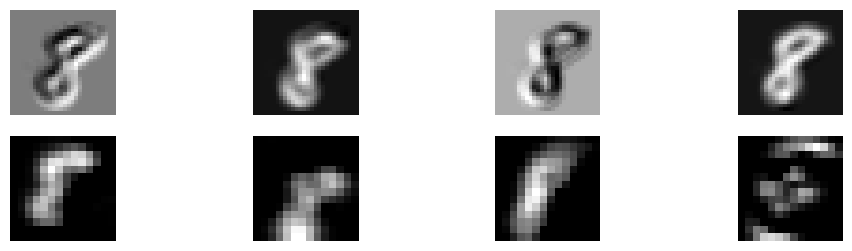

Epoch:11/15
Train error: 0.0063360570520162585
Train accuracy: 90.0%
Test error: 0.006579961776733399
Test accuracy: 92.0%


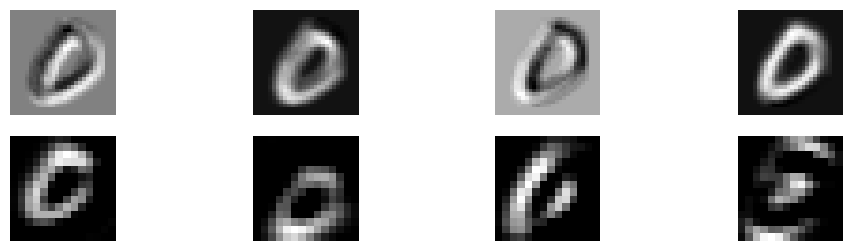

Epoch:12/15
Train error: 0.004990206234157086
Train accuracy: 91.9%
Test error: 0.004684426784515381
Test accuracy: 94.0%


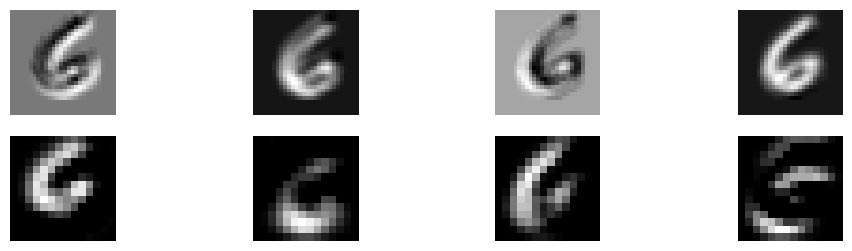

Epoch:13/15
Train error: 0.0040181979164481164
Train accuracy: 93.7%
Test error: 0.004662681668996811
Test accuracy: 94.0%


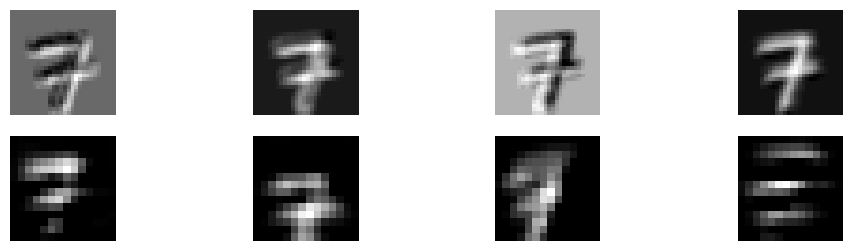

Epoch:14/15
Train error: 0.0037243332862854006
Train accuracy: 94.19999999999999%
Test error: 0.003299052491784096
Test accuracy: 96.0%


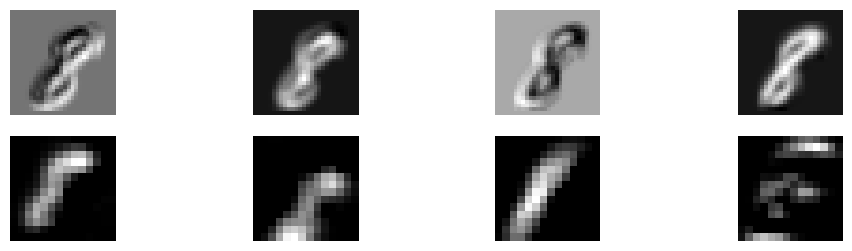

Epoch:15/15
Train error: 0.0030936601758003233
Train accuracy: 94.8%
Test error: 0.0032288898527622224
Test accuracy: 95.0%


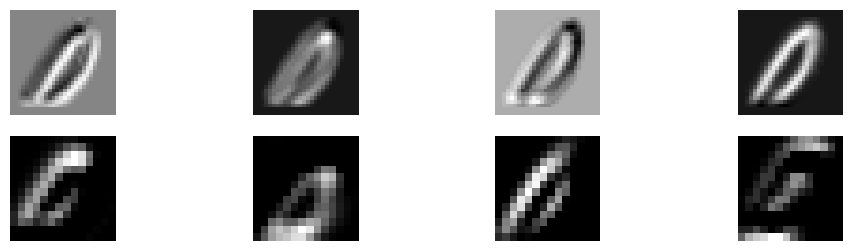

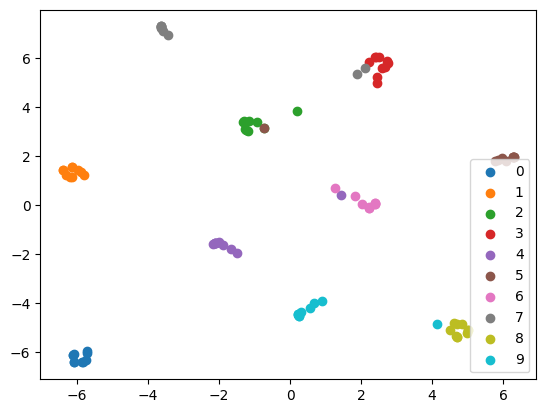

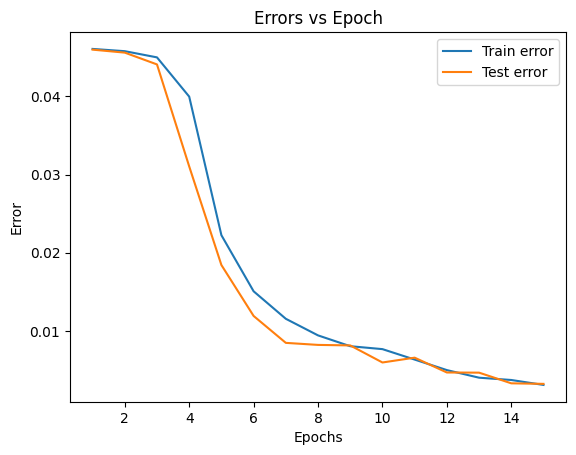

In [26]:
network = Network()
train(15, train_data, test_data, 50, 'momentum', True)

Epoch:1/15
Train error: 0.04440730333328247
Train accuracy: 26.3%
Test error: 0.04079763412475586
Test accuracy: 42.0%


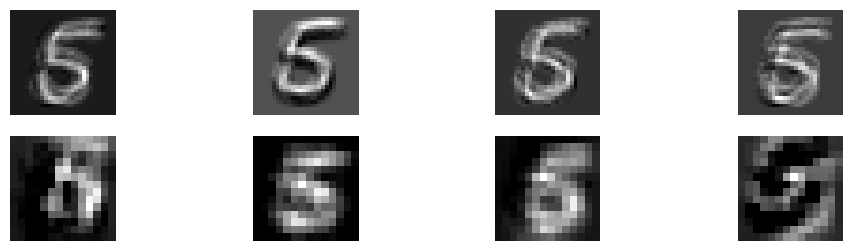

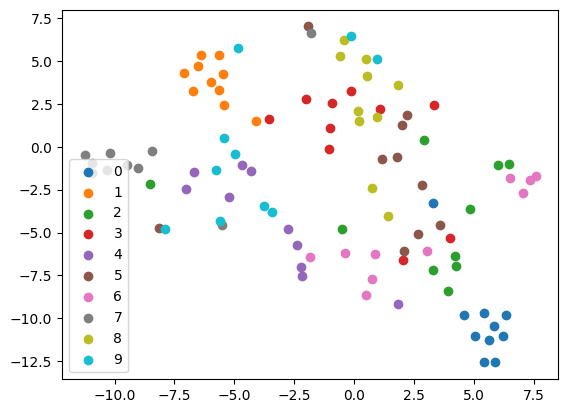

Epoch:2/15
Train error: 0.03431339228153229
Train accuracy: 54.1%
Test error: 0.029067293405532837
Test accuracy: 62.0%


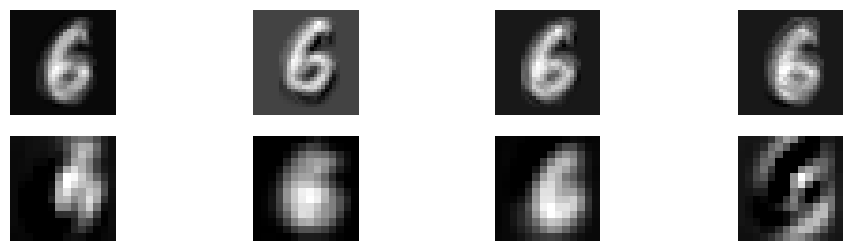

Epoch:3/15
Train error: 0.022422625303268433
Train accuracy: 71.89999999999999%
Test error: 0.020448286533355713
Test accuracy: 67.0%


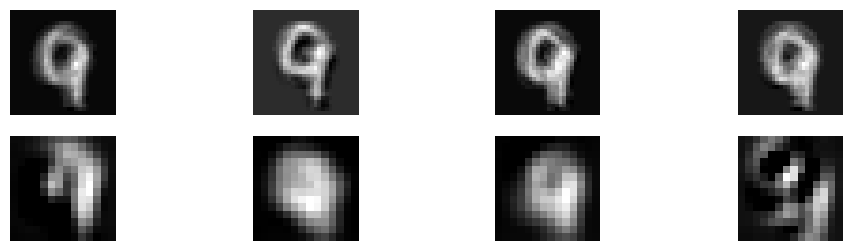

Epoch:4/15
Train error: 0.016324997782707216
Train accuracy: 76.9%
Test error: 0.01613209068775177
Test accuracy: 75.0%


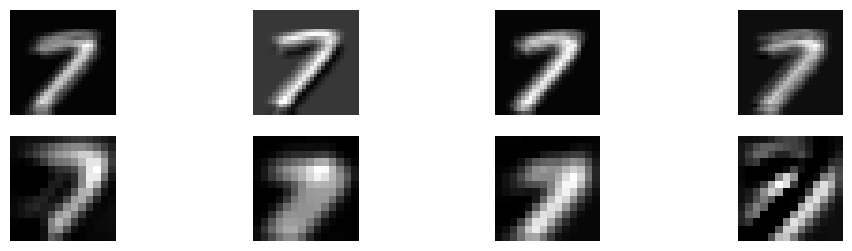

Epoch:5/15
Train error: 0.013510581672191619
Train accuracy: 80.2%
Test error: 0.012618190646171569
Test accuracy: 84.0%


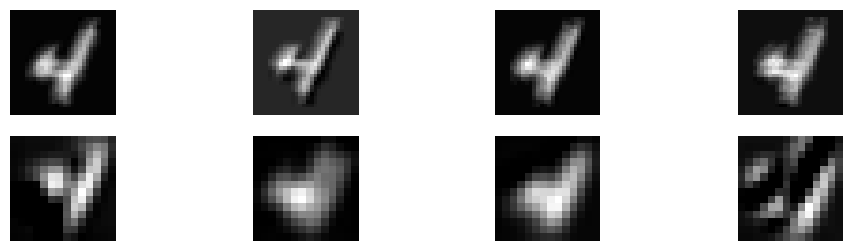

Epoch:6/15
Train error: 0.011632115244865418
Train accuracy: 83.3%
Test error: 0.012808834910392761
Test accuracy: 81.0%


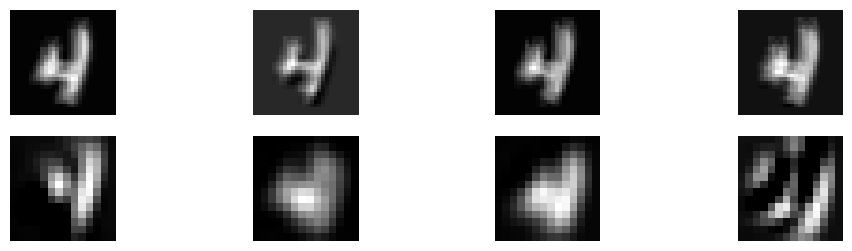

Epoch:7/15
Train error: 0.01067223557829857
Train accuracy: 84.1%
Test error: 0.00989298641681671
Test accuracy: 88.0%


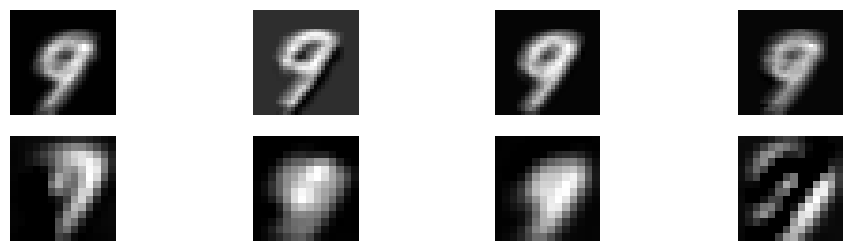

Epoch:8/15
Train error: 0.00954117676615715
Train accuracy: 85.6%
Test error: 0.010266256928443908
Test accuracy: 86.0%


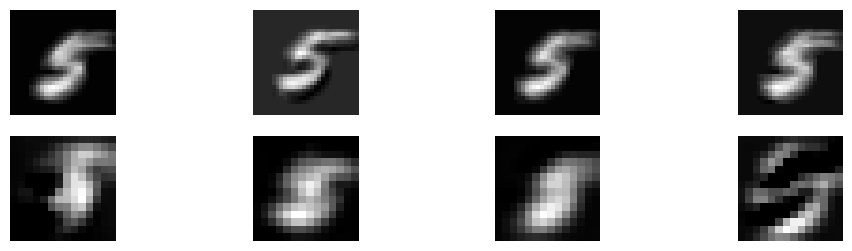

Epoch:9/15
Train error: 0.00905472218990326
Train accuracy: 85.3%
Test error: 0.008906098008155823
Test accuracy: 85.0%


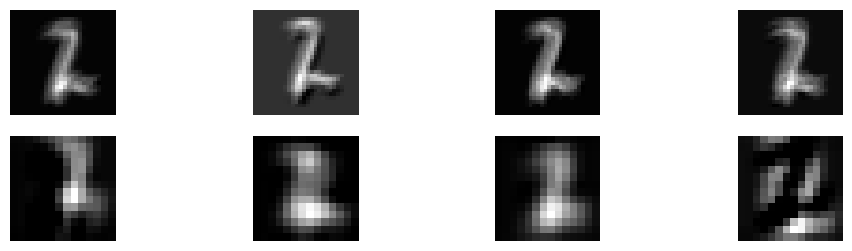

Epoch:10/15
Train error: 0.00828067620098591
Train accuracy: 86.8%
Test error: 0.01212203323841095
Test accuracy: 71.0%


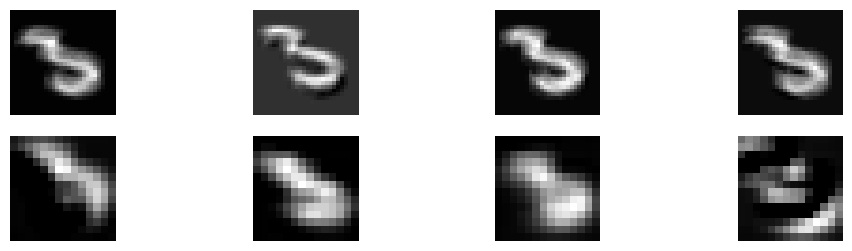

Epoch:11/15
Train error: 0.008225047841668129
Train accuracy: 87.5%
Test error: 0.008231182694435119
Test accuracy: 85.0%


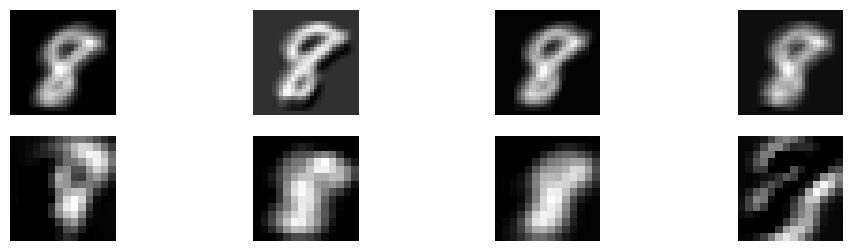

Epoch:12/15
Train error: 0.00744546402990818
Train accuracy: 89.1%
Test error: 0.009107295274734497
Test accuracy: 83.0%


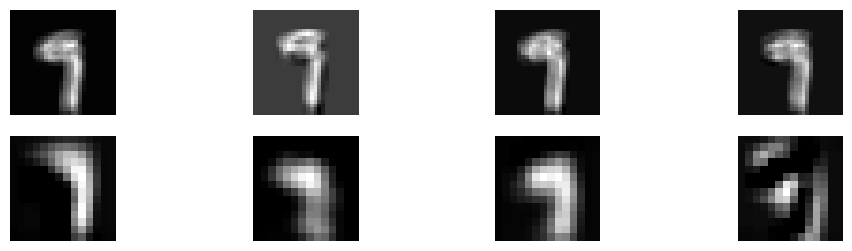

Epoch:13/15
Train error: 0.007009488791227341
Train accuracy: 89.3%
Test error: 0.007970887720584869
Test accuracy: 86.0%


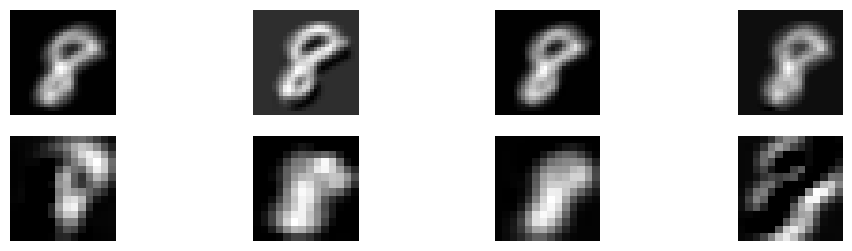

Epoch:14/15
Train error: 0.006770617246627807
Train accuracy: 89.1%
Test error: 0.006478576958179474
Test accuracy: 87.0%


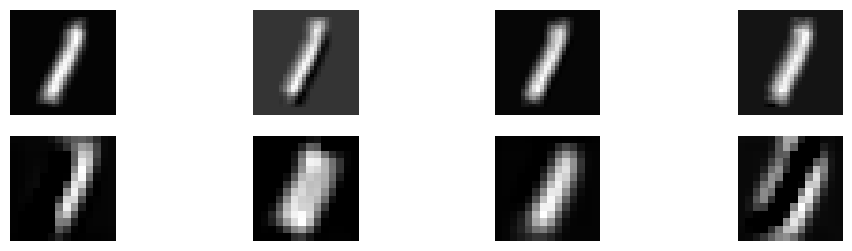

Epoch:15/15
Train error: 0.006217511385679245
Train accuracy: 90.3%
Test error: 0.0073044499754905704
Test accuracy: 85.0%


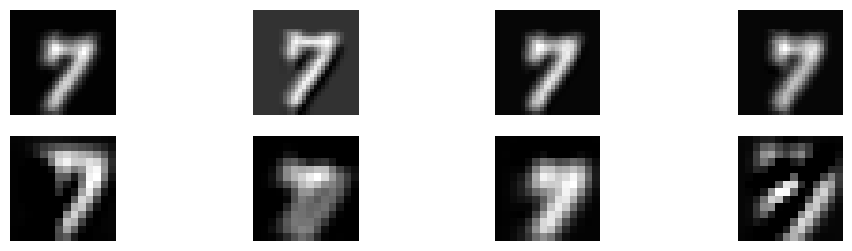

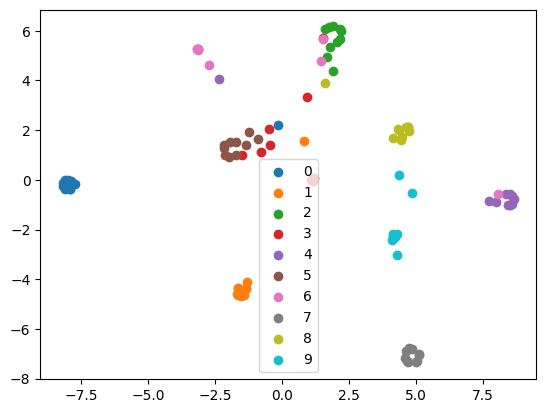

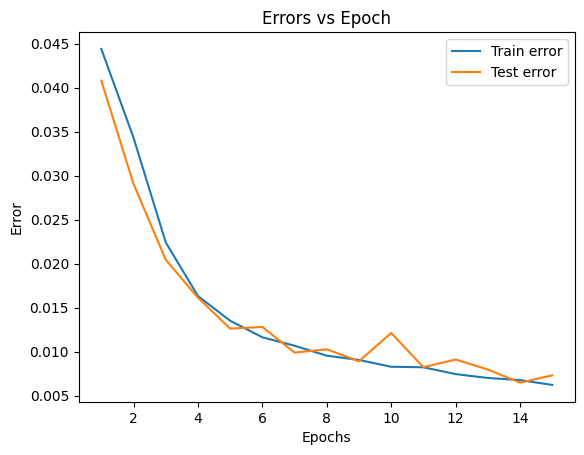

In [29]:
network = Network()
train(15, train_data, test_data, 50, 'rmsprop', True)

Batch size = 60, Epochs = 15

Epoch:1/15
Train error: 0.039196562767028806
Train accuracy: 9.5%
Test error: 0.04605804204940796
Test accuracy: 10.0%


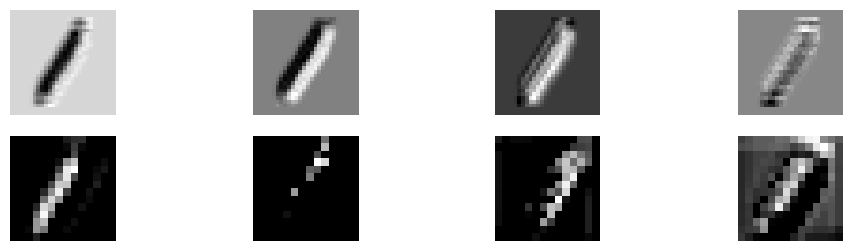

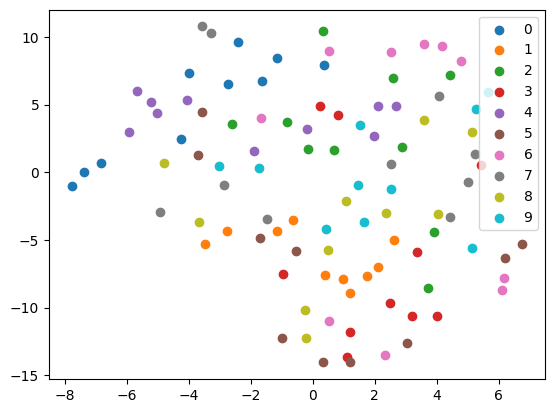

Epoch:2/15
Train error: 0.03909566450119019
Train accuracy: 11.1%
Test error: 0.04591108322143555
Test accuracy: 12.0%


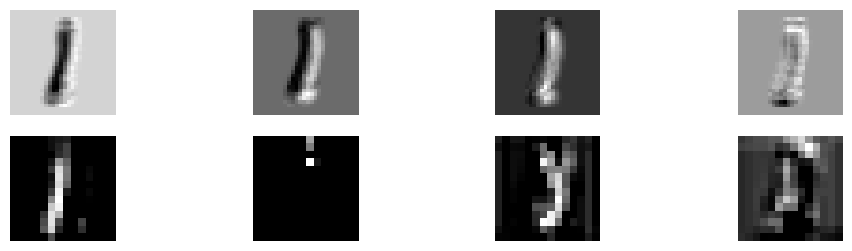

Epoch:3/15
Train error: 0.0389073543548584
Train accuracy: 14.499999999999998%
Test error: 0.0456022047996521
Test accuracy: 21.0%


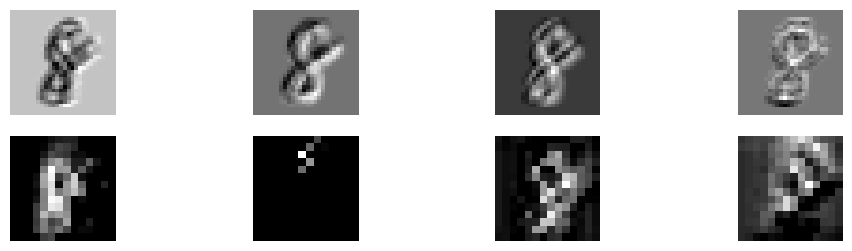

Epoch:4/15
Train error: 0.03832273292541504
Train accuracy: 22.900000000000002%
Test error: 0.04410318374633789
Test accuracy: 34.0%


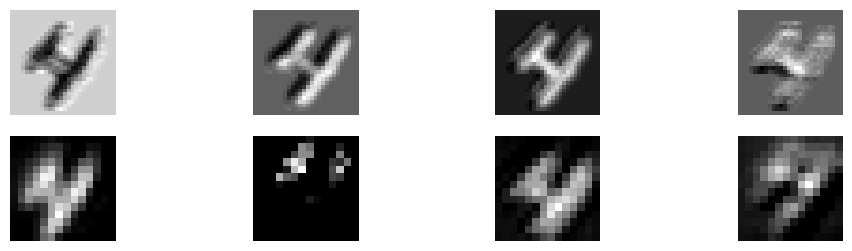

Epoch:5/15
Train error: 0.03431180119514465
Train accuracy: 38.0%
Test error: 0.03424914836883545
Test accuracy: 41.0%


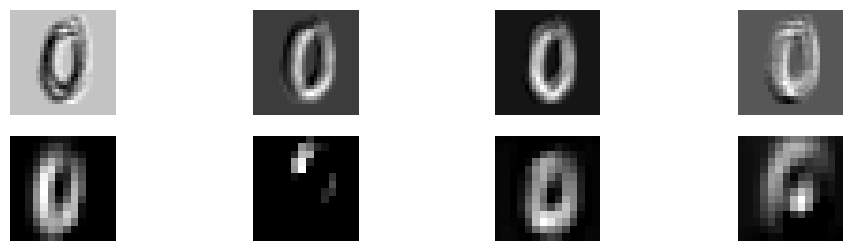

Epoch:6/15
Train error: 0.023723073720932006
Train accuracy: 55.50000000000001%
Test error: 0.01954799711704254
Test accuracy: 66.0%


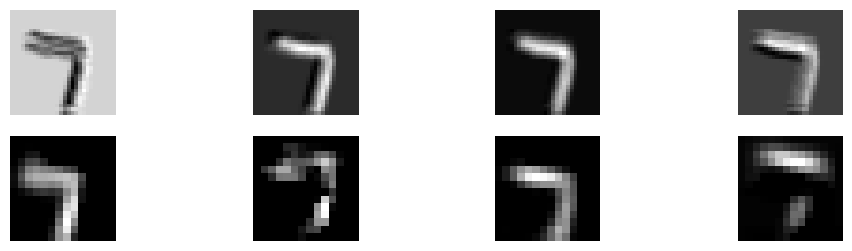

Epoch:7/15
Train error: 0.01854764986038208
Train accuracy: 66.3%
Test error: 0.014547490477561952
Test accuracy: 72.0%


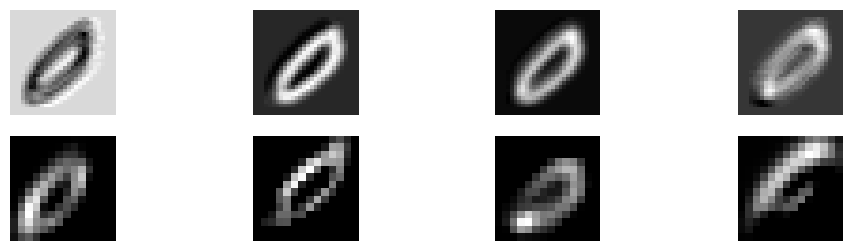

Epoch:8/15
Train error: 0.013884763181209564
Train accuracy: 73.3%
Test error: 0.014640843272209167
Test accuracy: 73.0%


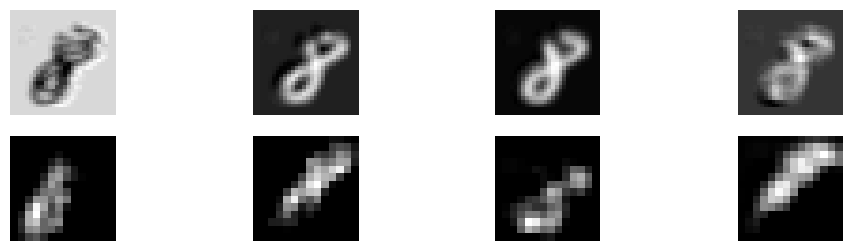

Epoch:9/15
Train error: 0.01017234840989113
Train accuracy: 80.30000000000001%
Test error: 0.011282734870910645
Test accuracy: 81.0%


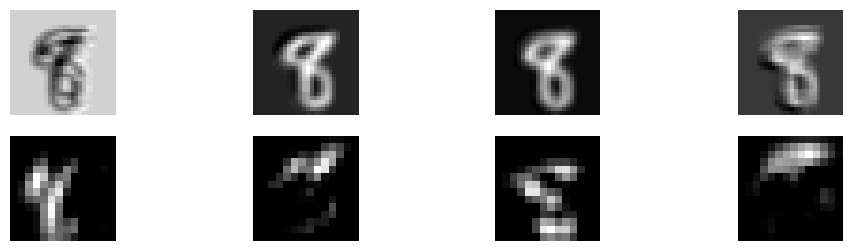

Epoch:10/15
Train error: 0.00757228097319603
Train accuracy: 84.7%
Test error: 0.012089757919311524
Test accuracy: 76.0%


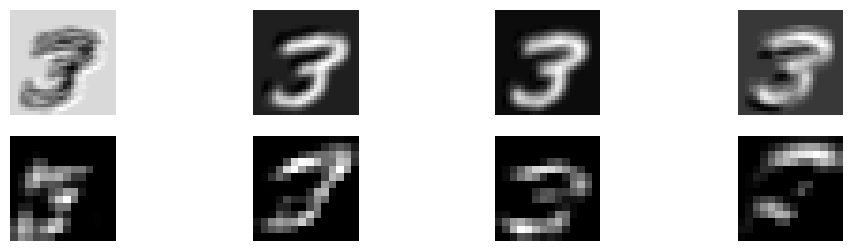

Epoch:11/15
Train error: 0.006463595643639564
Train accuracy: 88.3%
Test error: 0.008875377476215363
Test accuracy: 83.0%


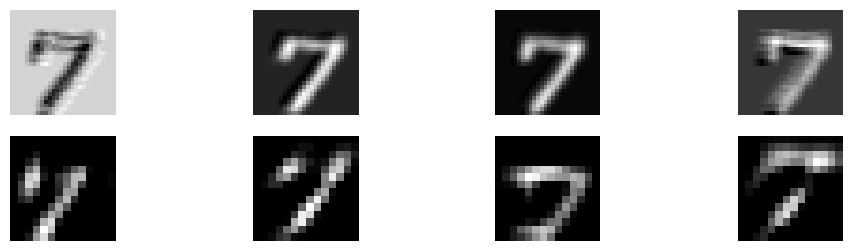

Epoch:12/15
Train error: 0.00633512943983078
Train accuracy: 87.4%
Test error: 0.00978687196969986
Test accuracy: 81.0%


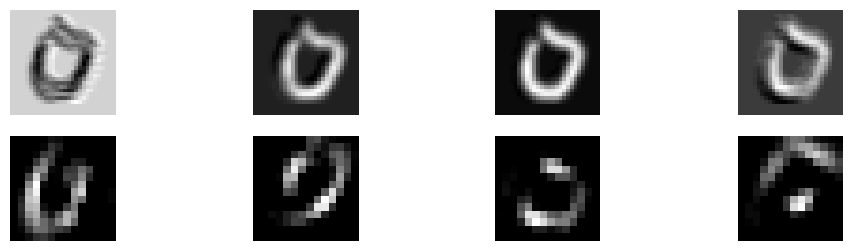

Epoch:13/15
Train error: 0.005578592985868454
Train accuracy: 89.7%
Test error: 0.005376862287521362
Test accuracy: 91.0%


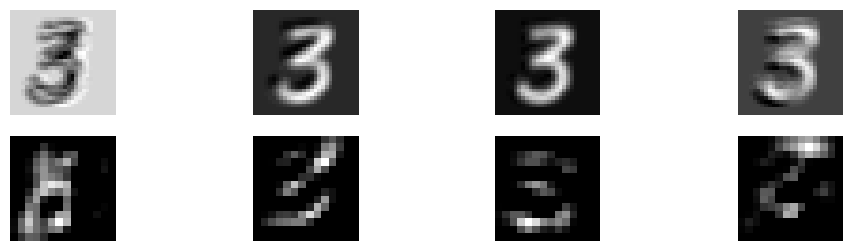

Epoch:14/15
Train error: 0.003524374768137932
Train accuracy: 93.89999999999999%
Test error: 0.0037561869621276856
Test accuracy: 96.0%


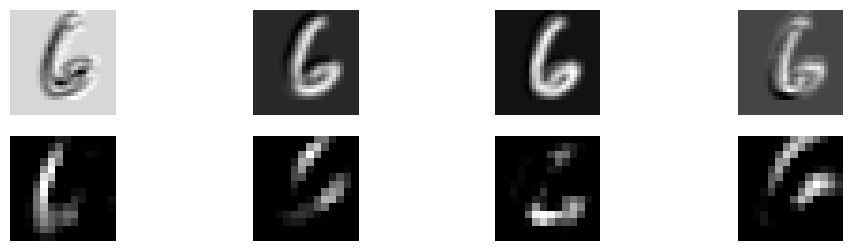

Epoch:15/15
Train error: 0.0032257191985845565
Train accuracy: 93.7%
Test error: 0.005197485238313675
Test accuracy: 91.0%


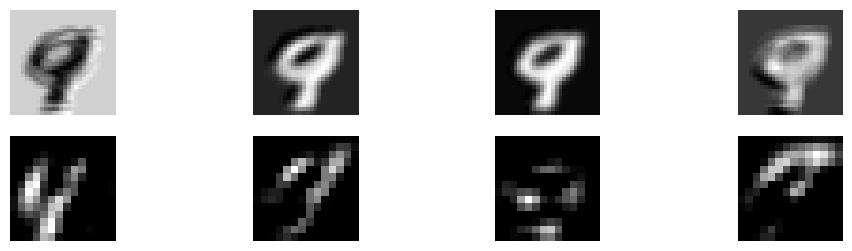

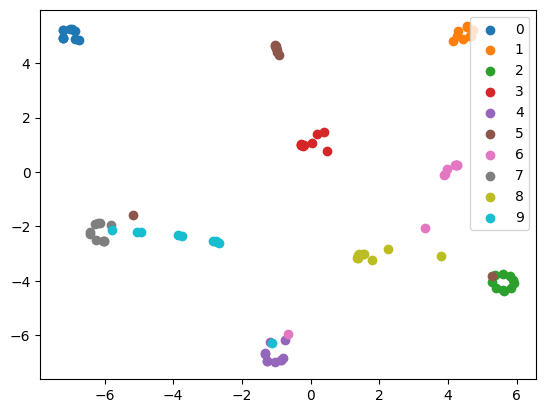

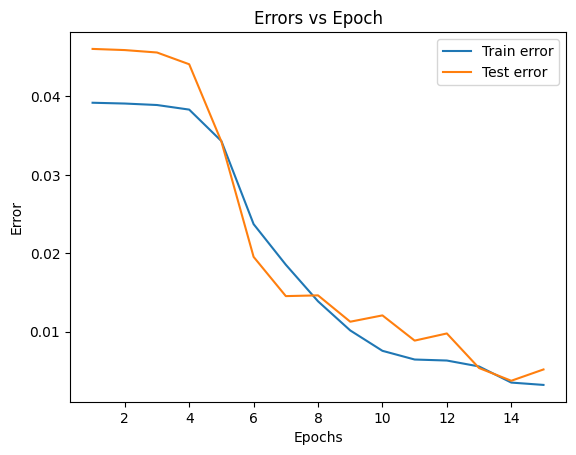

In [30]:
network = Network()
train(15, train_data, test_data, 60, 'sgd', True)

Epoch:1/15
Train error: 0.03918681120872498
Train accuracy: 10.0%
Test error: 0.046065692901611326
Test accuracy: 10.0%


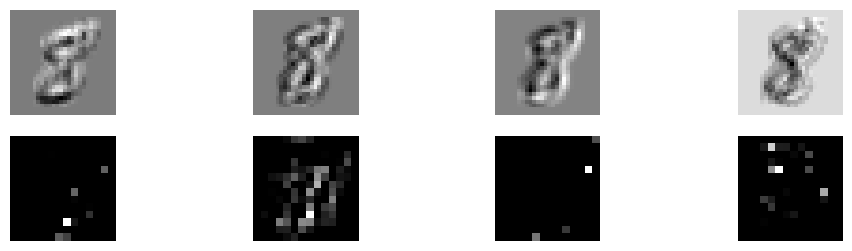

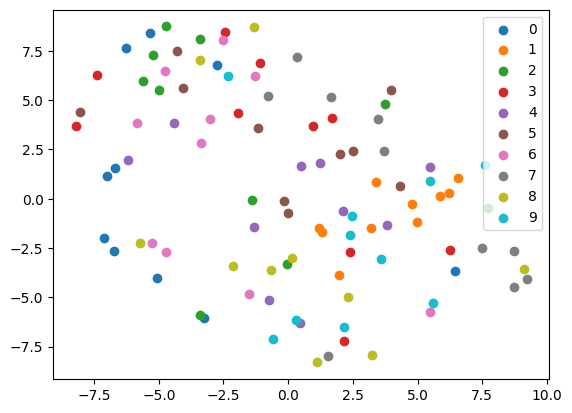

Epoch:2/15
Train error: 0.03915184378623962
Train accuracy: 10.0%
Test error: 0.04600759029388428
Test accuracy: 10.0%


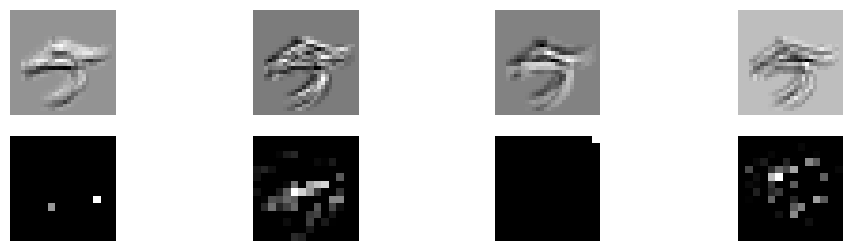

Epoch:3/15
Train error: 0.039110733985900877
Train accuracy: 10.0%
Test error: 0.04595590353012085
Test accuracy: 10.0%


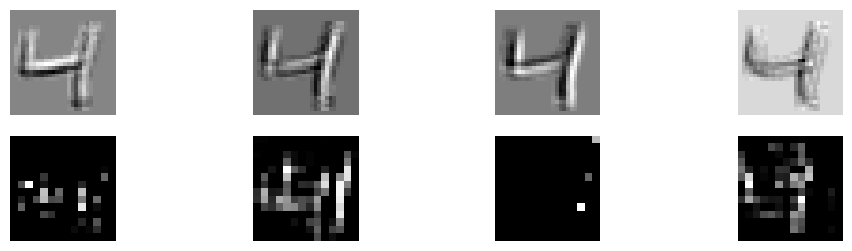

Epoch:4/15
Train error: 0.039055763483047484
Train accuracy: 10.0%
Test error: 0.04588699102401733
Test accuracy: 10.0%


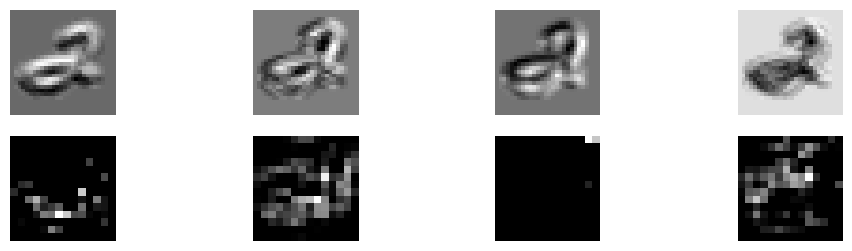

Epoch:5/15
Train error: 0.03897370600700378
Train accuracy: 10.2%
Test error: 0.04576371431350708
Test accuracy: 11.0%


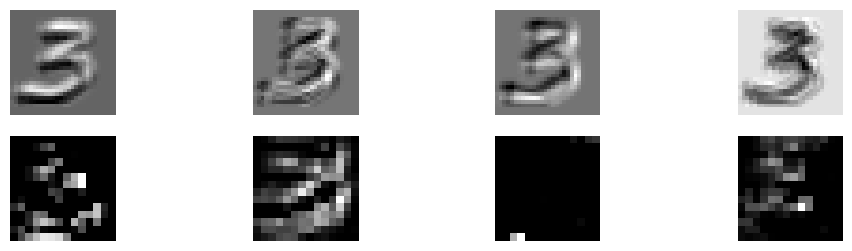

Epoch:6/15
Train error: 0.03881616806983948
Train accuracy: 11.899999999999999%
Test error: 0.045506258010864255
Test accuracy: 18.0%


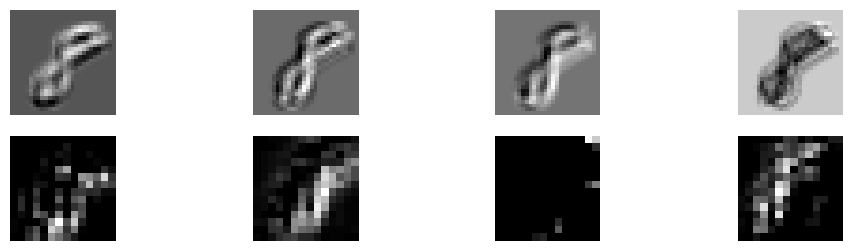

Epoch:7/15
Train error: 0.038442276477813724
Train accuracy: 31.4%
Test error: 0.0447403621673584
Test accuracy: 45.0%


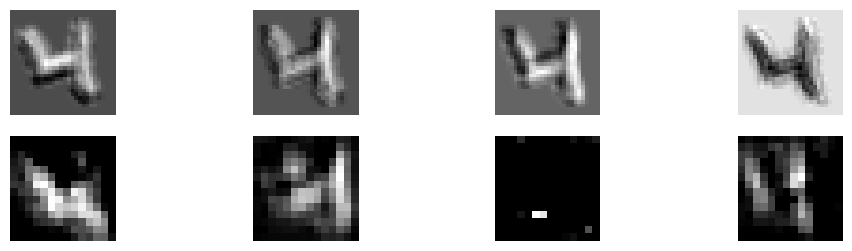

Epoch:8/15
Train error: 0.03706795120239258
Train accuracy: 38.3%
Test error: 0.04148670673370361
Test accuracy: 48.0%


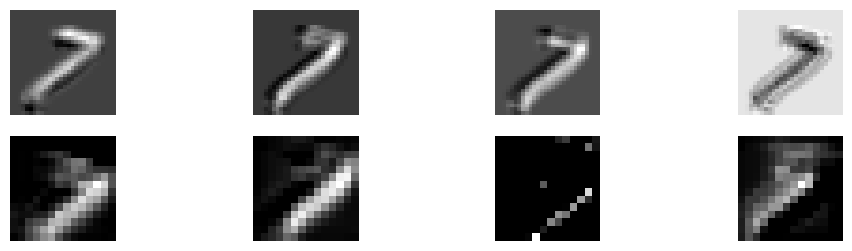

Epoch:9/15
Train error: 0.03023782968521118
Train accuracy: 48.8%
Test error: 0.028609176874160768
Test accuracy: 59.0%


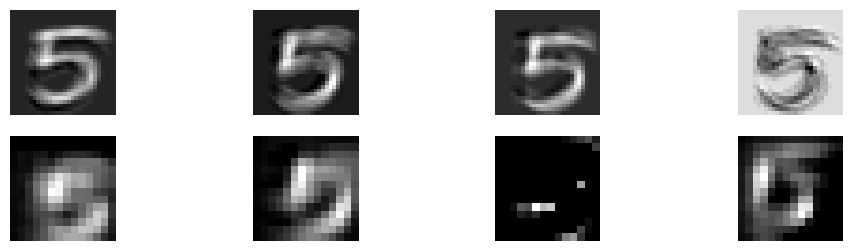

Epoch:10/15
Train error: 0.017923231482505797
Train accuracy: 65.3%
Test error: 0.021767739057540893
Test accuracy: 63.0%


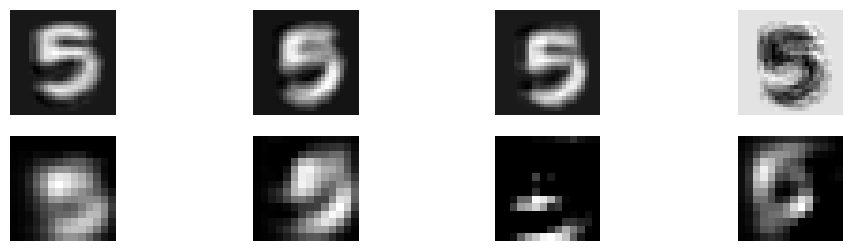

Epoch:11/15
Train error: 0.012515462040901183
Train accuracy: 76.0%
Test error: 0.014042838811874389
Test accuracy: 75.0%


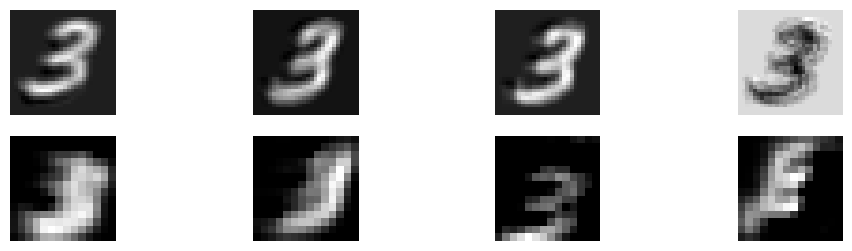

Epoch:12/15
Train error: 0.011377682417631148
Train accuracy: 77.3%
Test error: 0.011315907239913941
Test accuracy: 79.0%


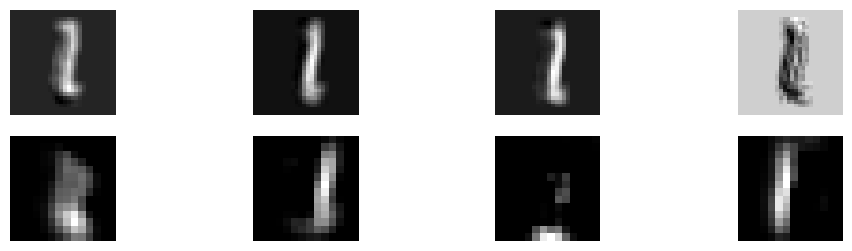

Epoch:13/15
Train error: 0.008686610758304595
Train accuracy: 83.0%
Test error: 0.01087772250175476
Test accuracy: 79.0%


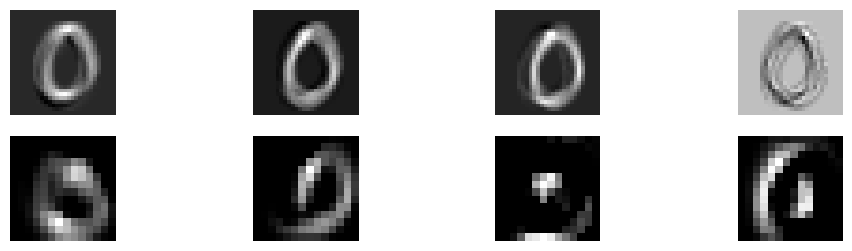

Epoch:14/15
Train error: 0.006653919473290444
Train accuracy: 87.8%
Test error: 0.010130943655967712
Test accuracy: 80.0%


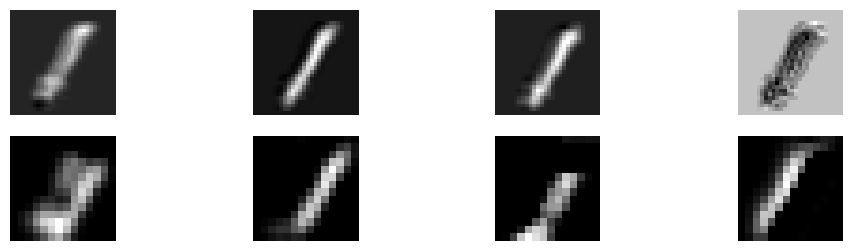

Epoch:15/15
Train error: 0.006113731011748314
Train accuracy: 88.7%
Test error: 0.01008308380842209
Test accuracy: 82.0%


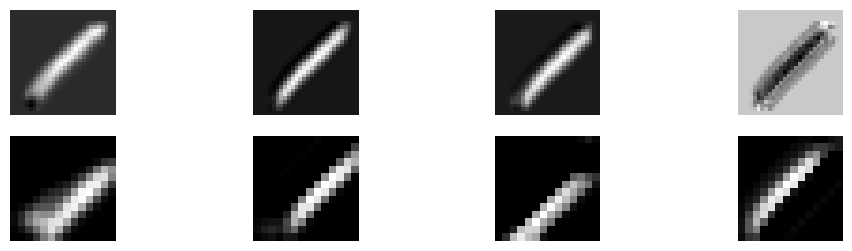

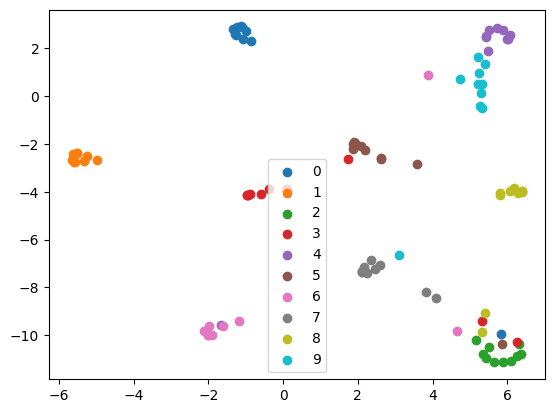

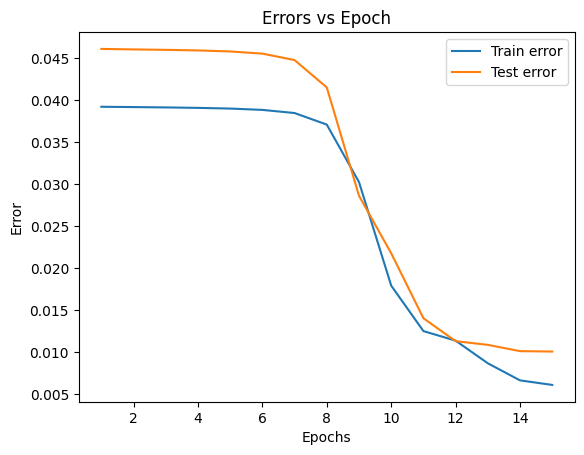

In [31]:
network = Network()
train(15, train_data, test_data, 60, 'momentum', True)

Epoch:1/15
Train error: 0.038858258485794064
Train accuracy: 10.6%
Test error: 0.04460044622421264
Test accuracy: 14.000000000000002%


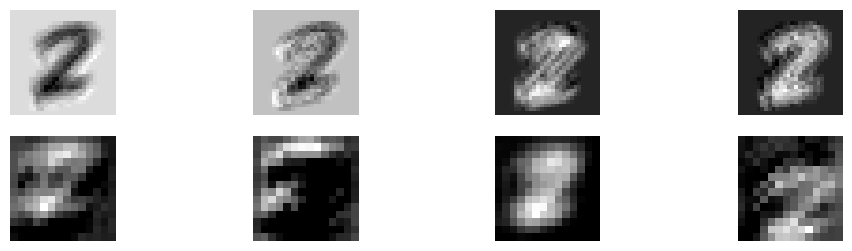

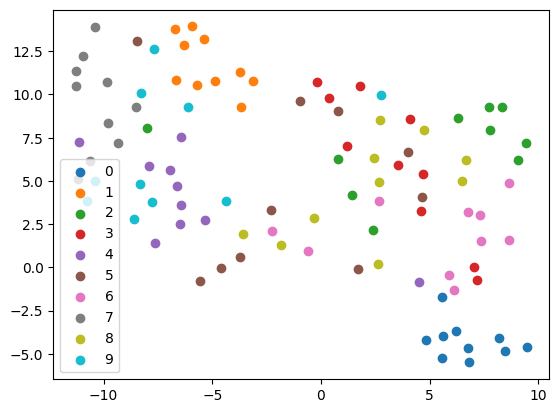

Epoch:2/15
Train error: 0.036162331104278564
Train accuracy: 34.0%
Test error: 0.039191575050354005
Test accuracy: 44.0%


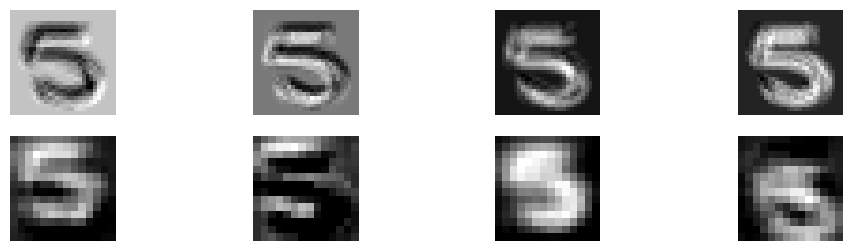

Epoch:3/15
Train error: 0.029203006744384766
Train accuracy: 59.599999999999994%
Test error: 0.02955941081047058
Test accuracy: 68.0%


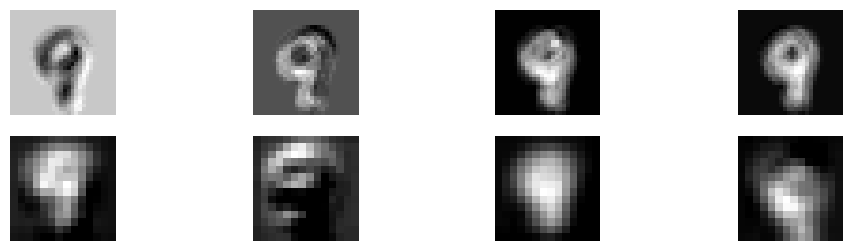

Epoch:4/15
Train error: 0.021238667130470276
Train accuracy: 69.89999999999999%
Test error: 0.022411906719207765
Test accuracy: 65.0%


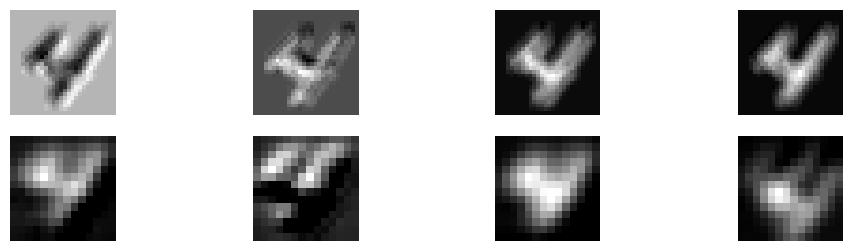

Epoch:5/15
Train error: 0.016053009927272797
Train accuracy: 75.3%
Test error: 0.01770118236541748
Test accuracy: 76.0%


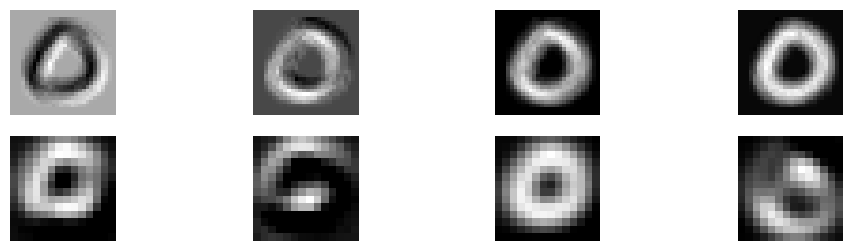

Epoch:6/15
Train error: 0.013043015539646149
Train accuracy: 78.3%
Test error: 0.014138861298561097
Test accuracy: 79.0%


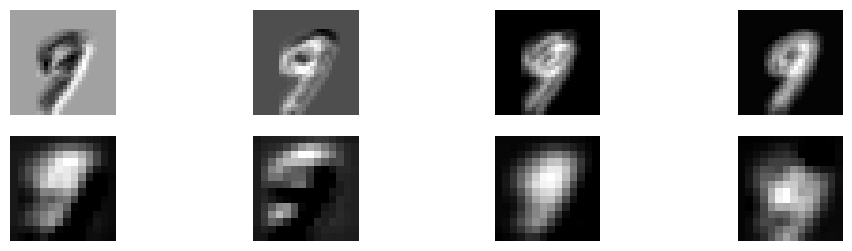

Epoch:7/15
Train error: 0.011296504378318787
Train accuracy: 80.5%
Test error: 0.011733982563018799
Test accuracy: 85.0%


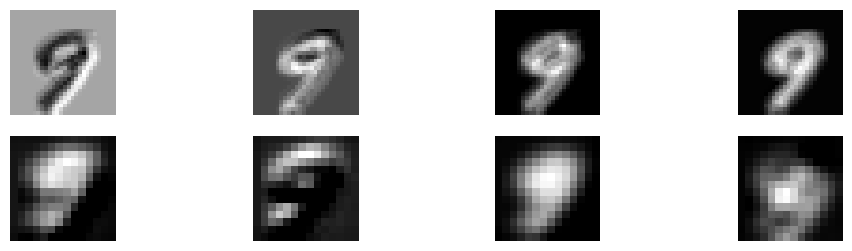

Epoch:8/15
Train error: 0.010149680018424988
Train accuracy: 82.5%
Test error: 0.014037131667137145
Test accuracy: 74.0%


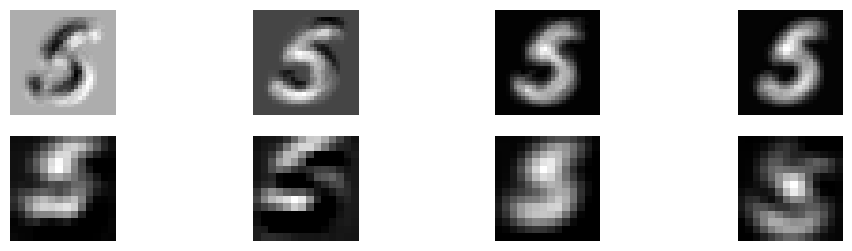

Epoch:9/15
Train error: 0.009433577954769134
Train accuracy: 83.6%
Test error: 0.009126912057399749
Test accuracy: 86.0%


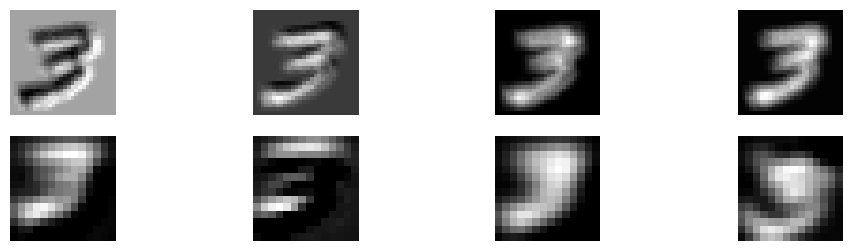

Epoch:10/15
Train error: 0.008618709832429886
Train accuracy: 83.6%
Test error: 0.009742494523525238
Test accuracy: 83.0%


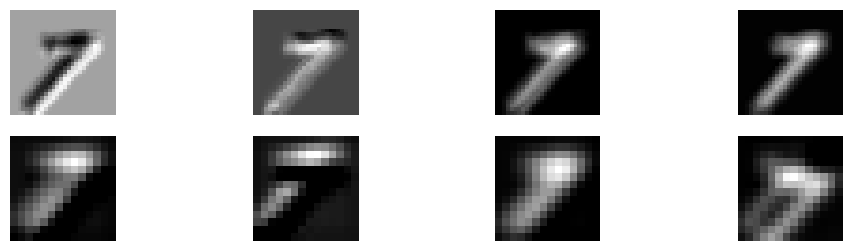

Epoch:11/15
Train error: 0.008178582698106765
Train accuracy: 85.9%
Test error: 0.008896693289279937
Test accuracy: 83.0%


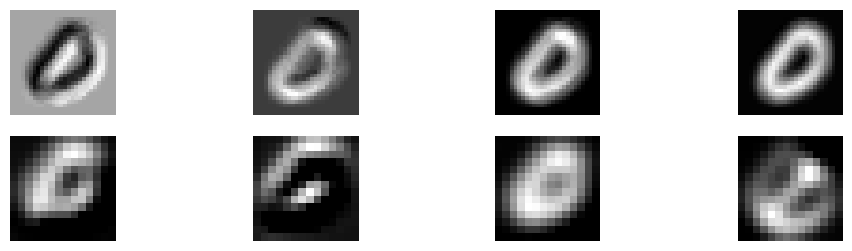

Epoch:12/15
Train error: 0.007633486807346344
Train accuracy: 86.3%
Test error: 0.011176691651344299
Test accuracy: 79.0%


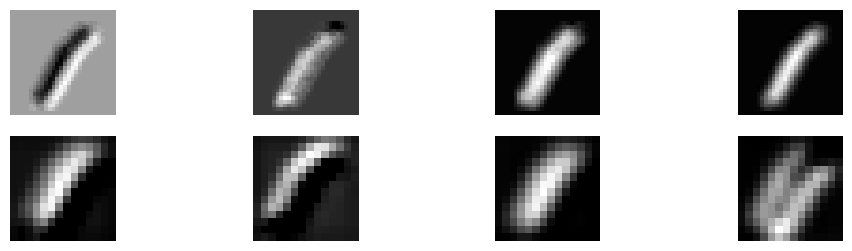

Epoch:13/15
Train error: 0.007170307457447052
Train accuracy: 87.1%
Test error: 0.009122418761253357
Test accuracy: 86.0%


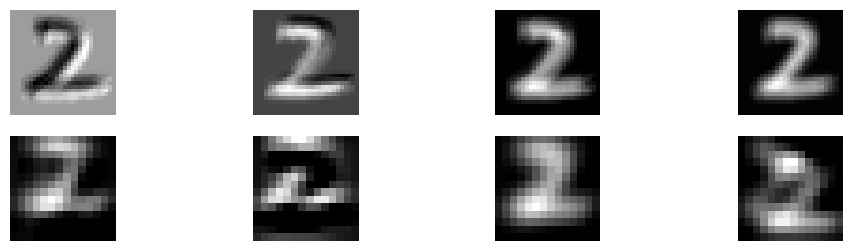

Epoch:14/15
Train error: 0.0068171114474534986
Train accuracy: 88.1%
Test error: 0.007648667097091675
Test accuracy: 87.0%


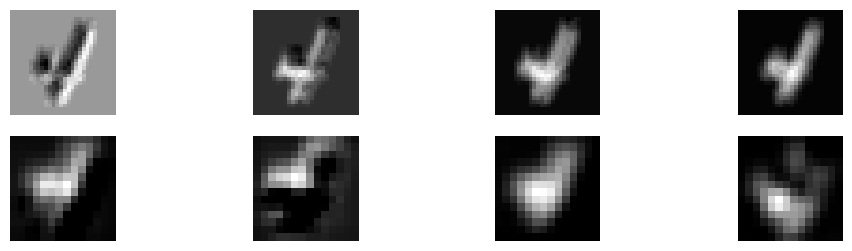

Epoch:15/15
Train error: 0.00649202324450016
Train accuracy: 89.4%
Test error: 0.009125196337699891
Test accuracy: 88.0%


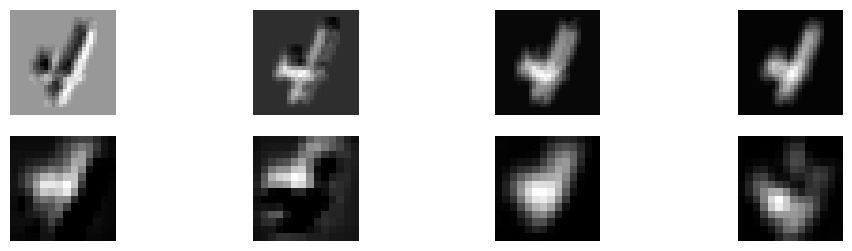

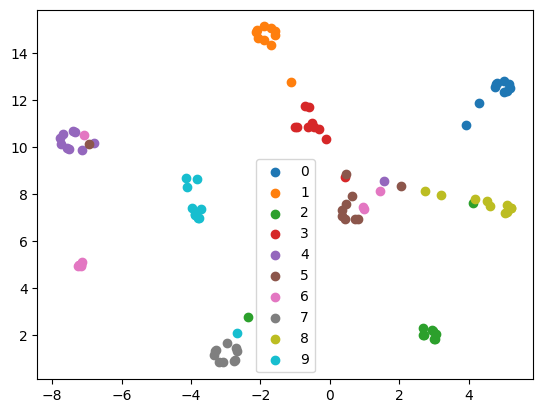

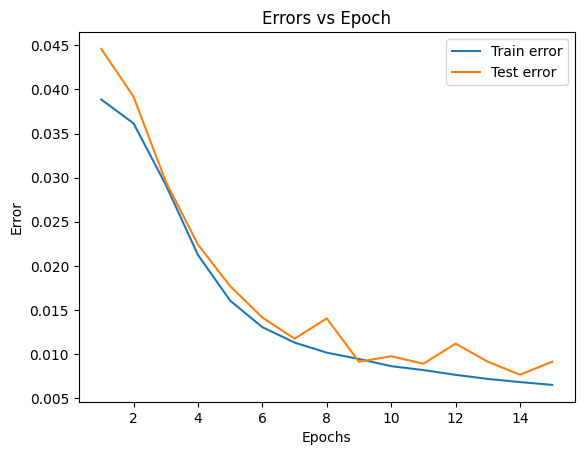

In [32]:
network = Network()
train(15, train_data, test_data, 60, 'rmsprop', True)

Batch size = 60, Epochs = 20

Epoch:1/20
Train error: 0.03794232130050659
Train accuracy: 21.9%
Test error: 0.04238948822021484
Test accuracy: 19.0%


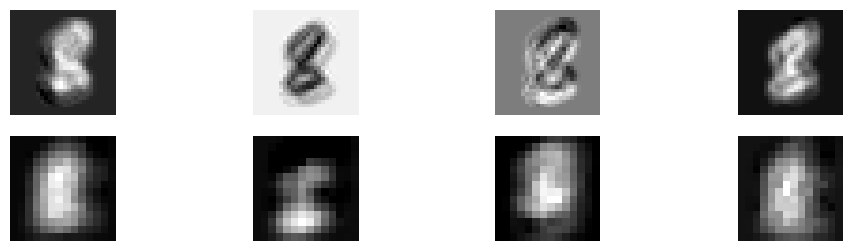

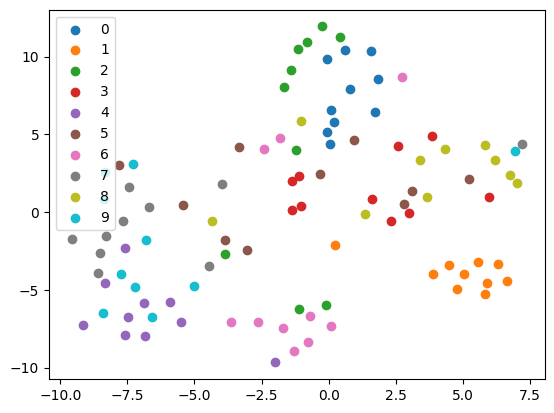

Epoch:2/20
Train error: 0.03292956006526947
Train accuracy: 42.0%
Test error: 0.034848178625106814
Test accuracy: 55.00000000000001%


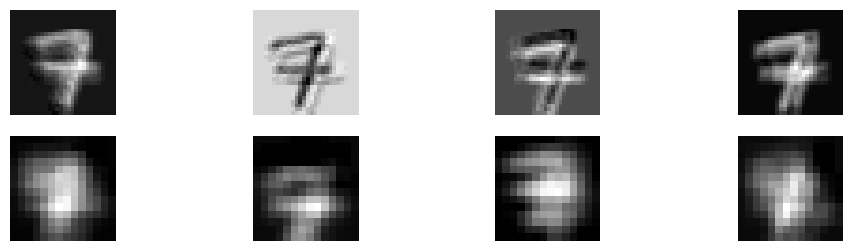

Epoch:3/20
Train error: 0.02531368887424469
Train accuracy: 61.1%
Test error: 0.026825809478759767
Test accuracy: 59.0%


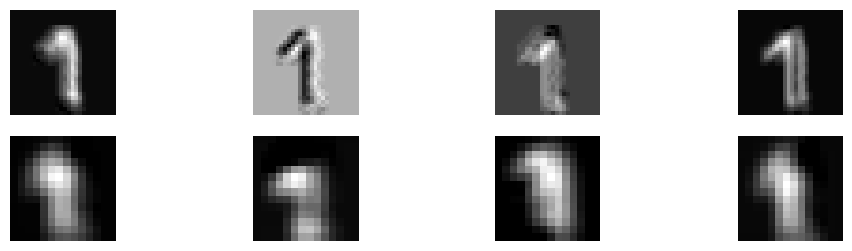

Epoch:4/20
Train error: 0.019318587958812715
Train accuracy: 68.2%
Test error: 0.020691769123077394
Test accuracy: 66.0%


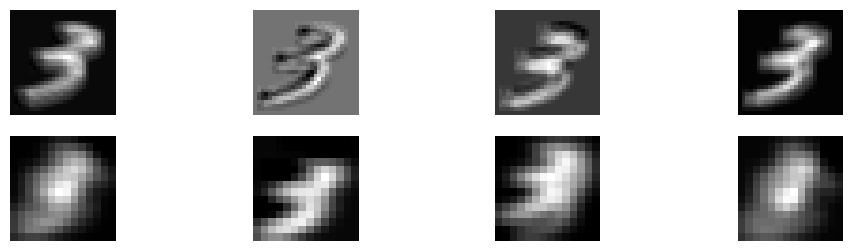

Epoch:5/20
Train error: 0.015661804020404815
Train accuracy: 73.2%
Test error: 0.018155438899993895
Test accuracy: 76.0%


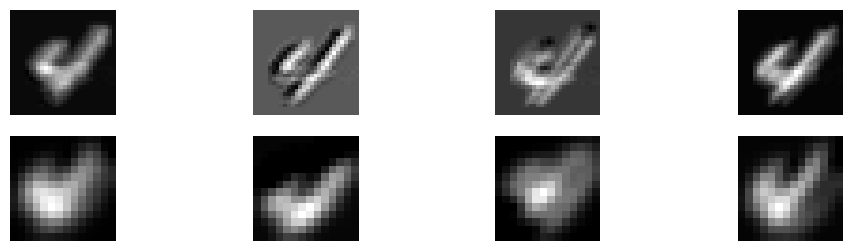

Epoch:6/20
Train error: 0.013281300723552703
Train accuracy: 77.10000000000001%
Test error: 0.01696016073226929
Test accuracy: 77.0%


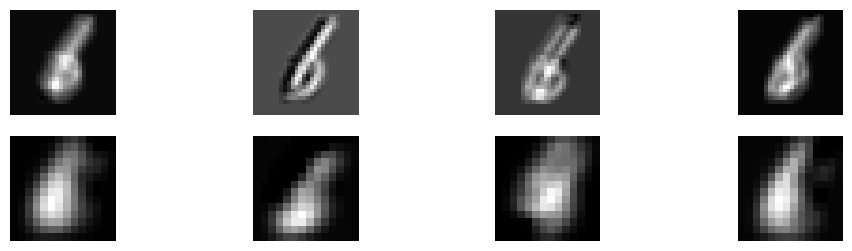

Epoch:7/20
Train error: 0.011929224252700805
Train accuracy: 78.4%
Test error: 0.014489330053329467
Test accuracy: 79.0%


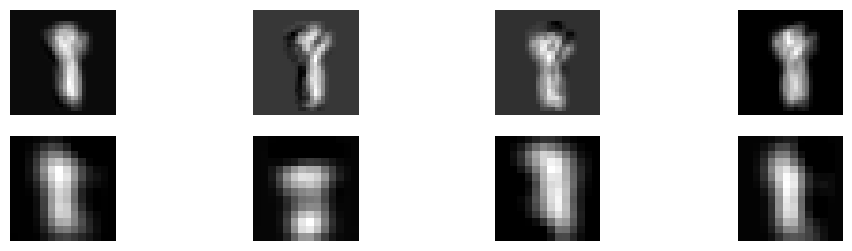

Epoch:8/20
Train error: 0.010667730659246444
Train accuracy: 80.9%
Test error: 0.011585571765899659
Test accuracy: 87.0%


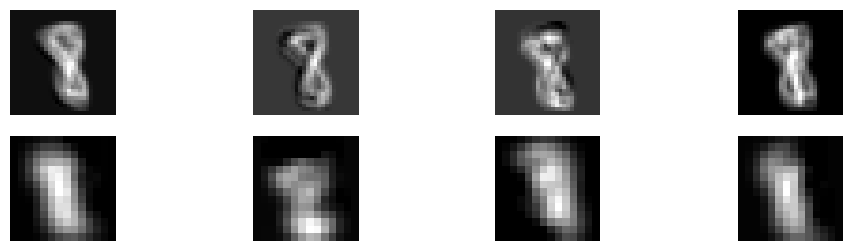

Epoch:9/20
Train error: 0.010162381172180176
Train accuracy: 81.3%
Test error: 0.013770704269409179
Test accuracy: 75.0%


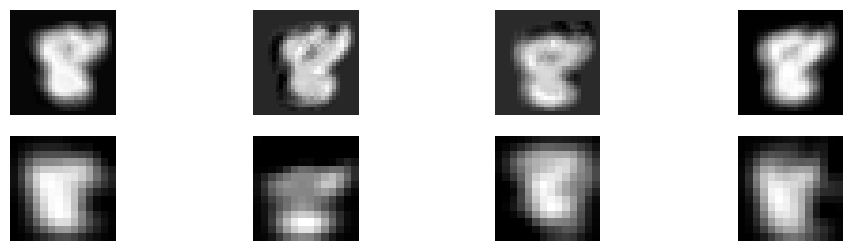

Epoch:10/20
Train error: 0.009293982744216918
Train accuracy: 83.39999999999999%
Test error: 0.011113885939121246
Test accuracy: 83.0%


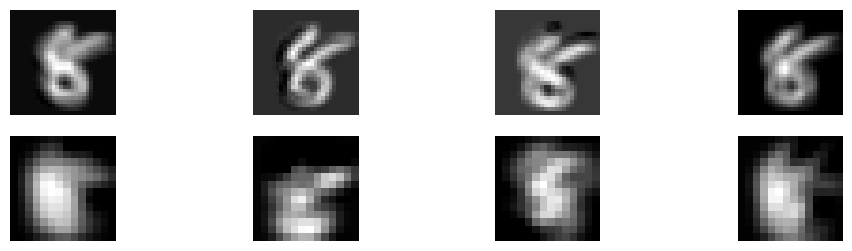

Epoch:11/20
Train error: 0.008810594528913498
Train accuracy: 84.39999999999999%
Test error: 0.011545975804328918
Test accuracy: 84.0%


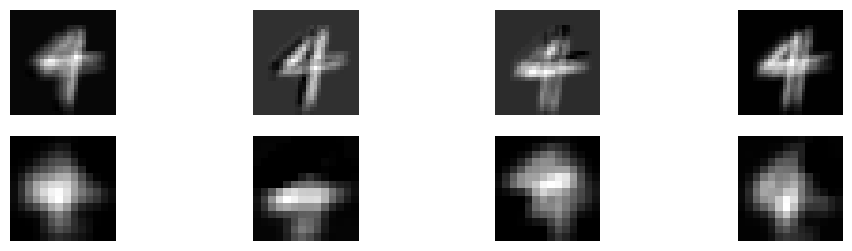

Epoch:12/20
Train error: 0.00825906354188919
Train accuracy: 85.7%
Test error: 0.008202952444553374
Test accuracy: 86.0%


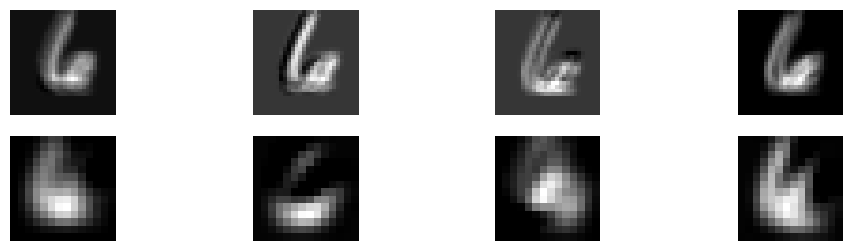

Epoch:13/20
Train error: 0.007509292855858803
Train accuracy: 86.0%
Test error: 0.009951286315917969
Test accuracy: 84.0%


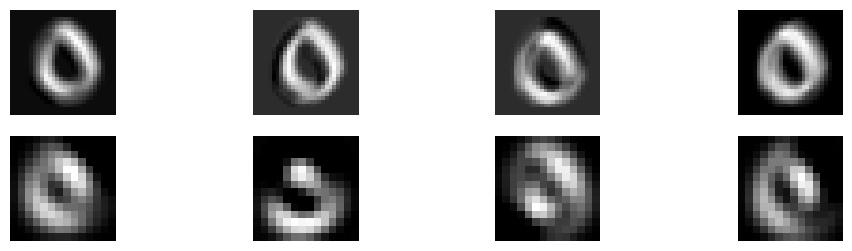

Epoch:14/20
Train error: 0.006942840307950973
Train accuracy: 87.8%
Test error: 0.006735373735427857
Test accuracy: 91.0%


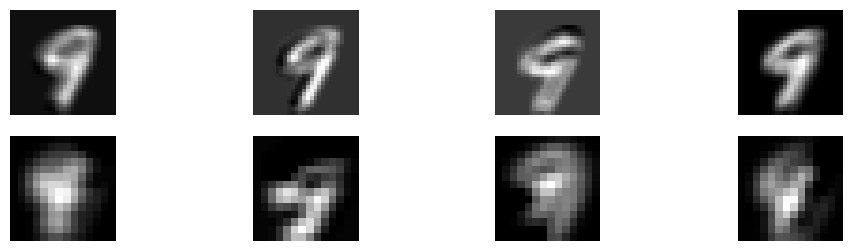

Epoch:15/20
Train error: 0.0064643420279026035
Train accuracy: 88.9%
Test error: 0.008939576148986817
Test accuracy: 86.0%


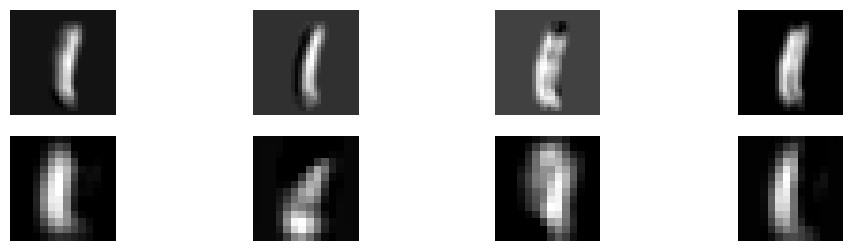

Epoch:16/20
Train error: 0.006384955167770386
Train accuracy: 87.3%
Test error: 0.008517856299877167
Test accuracy: 81.0%


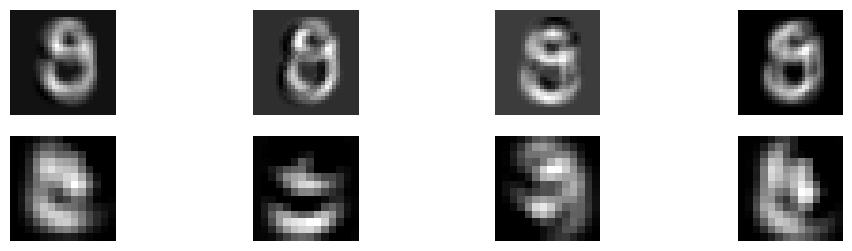

Epoch:17/20
Train error: 0.005703197747468948
Train accuracy: 89.8%
Test error: 0.005538383424282074
Test accuracy: 92.0%


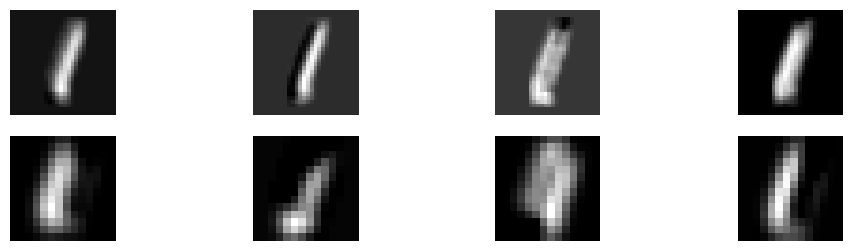

Epoch:18/20
Train error: 0.005898656189441681
Train accuracy: 89.8%
Test error: 0.005478369295597077
Test accuracy: 91.0%


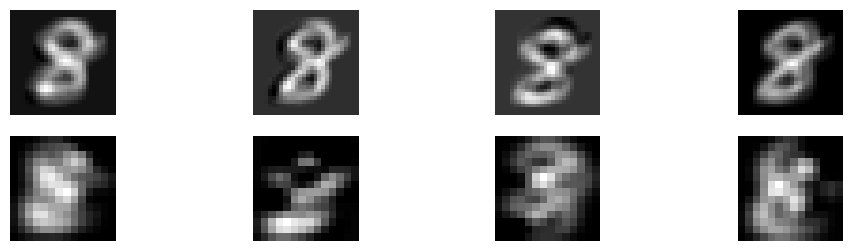

Epoch:19/20
Train error: 0.005303608074784279
Train accuracy: 89.9%
Test error: 0.005317806005477905
Test accuracy: 92.0%


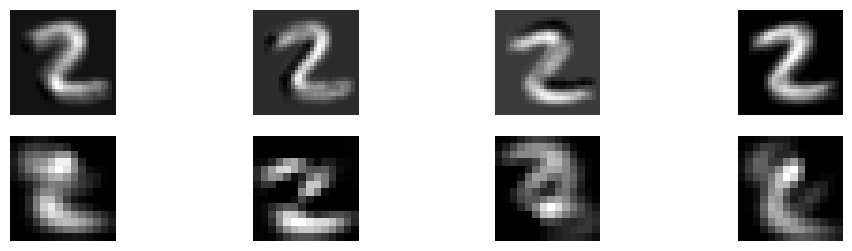

Epoch:20/20
Train error: 0.004955988228321075
Train accuracy: 90.7%
Test error: 0.004828644990921021
Test accuracy: 93.0%


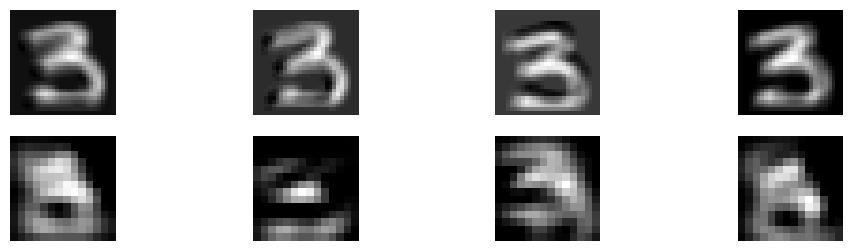

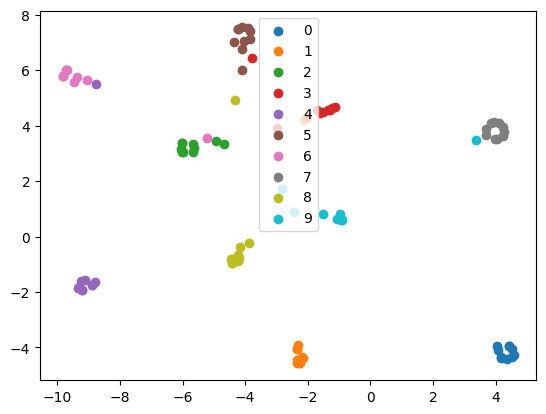

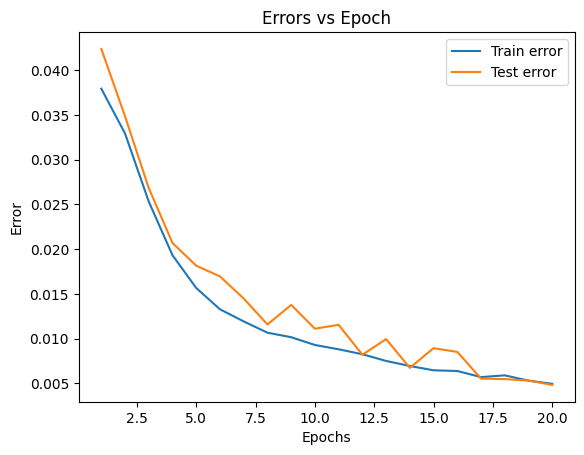

In [33]:
network = Network()
train(20, train_data, test_data, 60, 'rmsprop', True)

5.

In [34]:
class Network_dropout(nn.Module):
  def __init__(self, dr):
    self.dr = dr
    super(Network_dropout, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1, padding=2)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride=1, padding=2)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.flatten = nn.Identity()

    self.fc = nn.Sequential(
        nn.Linear(4 * 7 * 7, 49),
        nn.ReLU(),
        nn.Dropout(self.dr),
        nn.Linear(49, 10),
        nn.Softmax(dim=1)
    )

  def forward(self, x):

    x = F.relu(self.conv1(x))
    x = self.maxpool1(x)

    x = F.relu(self.conv2(x))
    x = self.maxpool2(x)

    x_flat = x.view(-1, 196)

    x_out = self.fc(x_flat)

    return x_out, x_flat

  def vis(self, x):
    slices = []
    x = self.conv1(x)
    slices.append(x)
    x = F.relu(x)
    x = self.maxpool1(x)
    x = F.relu(self.conv2(x))
    slices.append(x)
    return slices


Dropout rate = 0.2

Epoch:1/15
Train error: 0.04587194538116455
Train accuracy: 18.2%
Test error: 0.04538791418075561
Test accuracy: 20.0%


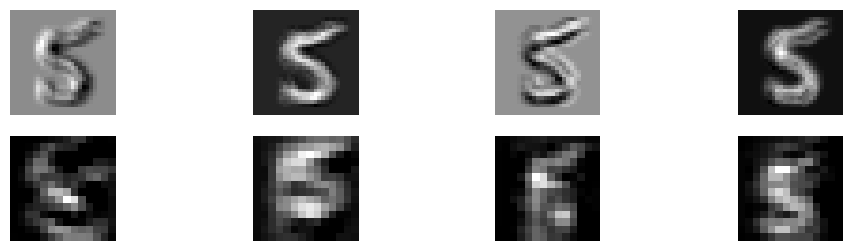

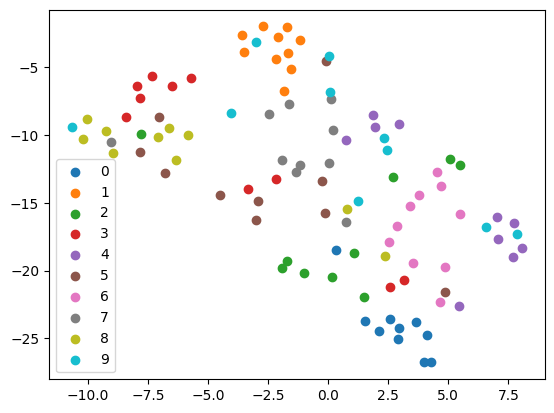

Epoch:2/15
Train error: 0.04428218221664429
Train accuracy: 29.9%
Test error: 0.04283570289611816
Test accuracy: 42.0%


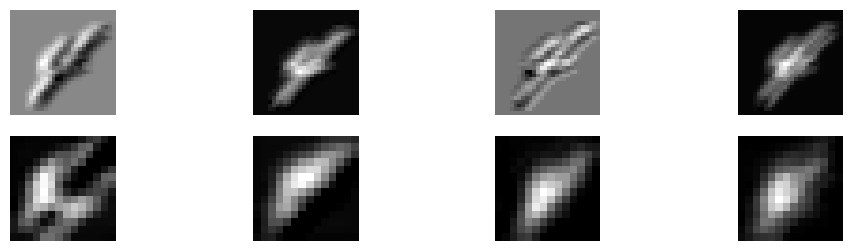

Epoch:3/15
Train error: 0.040975777626037595
Train accuracy: 53.5%
Test error: 0.03932107806205749
Test accuracy: 64.0%


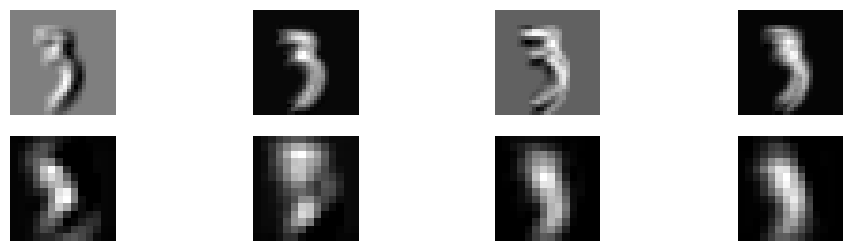

Epoch:4/15
Train error: 0.03855293905735016
Train accuracy: 60.8%
Test error: 0.0375605857372284
Test accuracy: 66.0%


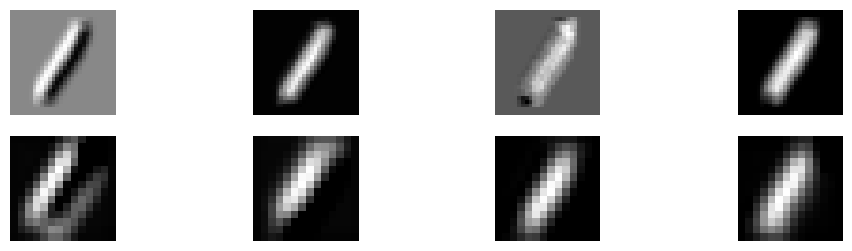

Epoch:5/15
Train error: 0.03714858162403107
Train accuracy: 64.5%
Test error: 0.03660516262054443
Test accuracy: 68.0%


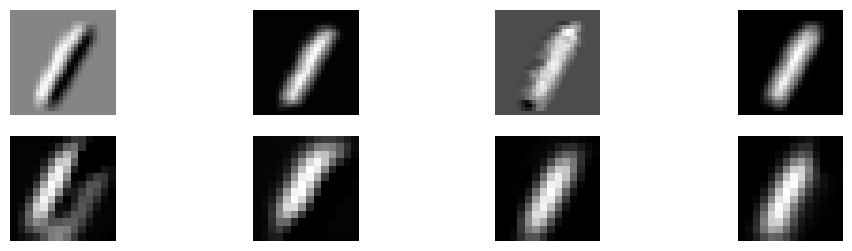

Epoch:6/15
Train error: 0.036371594905853274
Train accuracy: 67.9%
Test error: 0.03573298454284668
Test accuracy: 72.0%


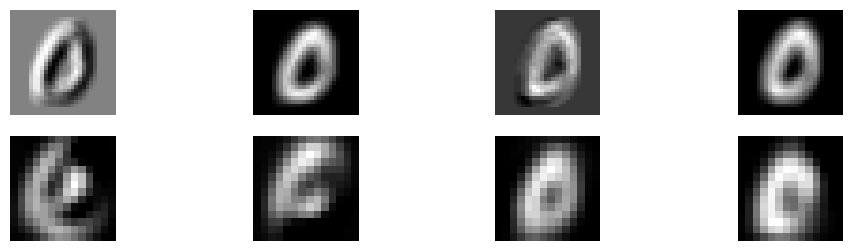

Epoch:7/15
Train error: 0.0358380206823349
Train accuracy: 68.8%
Test error: 0.035334552526474
Test accuracy: 72.0%


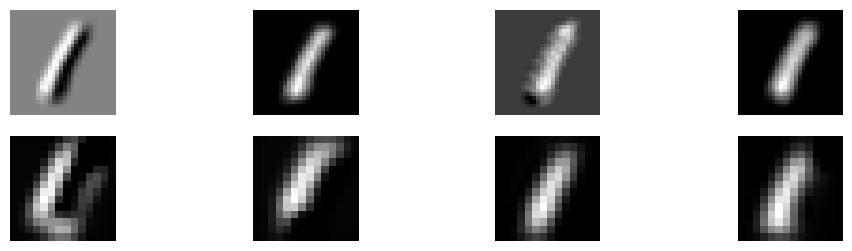

Epoch:8/15
Train error: 0.03499522244930267
Train accuracy: 73.6%
Test error: 0.03461873054504395
Test accuracy: 78.0%


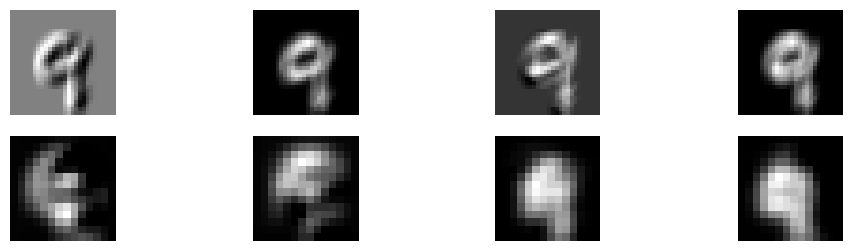

Epoch:9/15
Train error: 0.034749701142311094
Train accuracy: 74.0%
Test error: 0.034165140390396115
Test accuracy: 80.0%


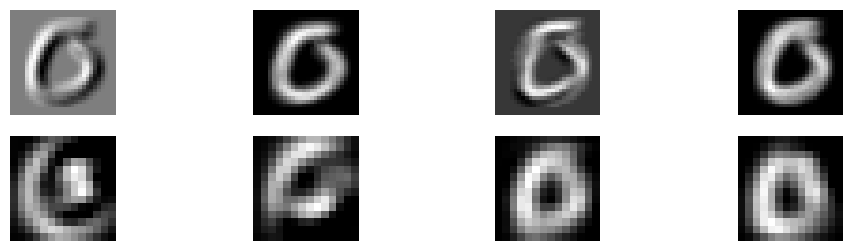

Epoch:10/15
Train error: 0.034057321190834045
Train accuracy: 78.10000000000001%
Test error: 0.033600404262542724
Test accuracy: 82.0%


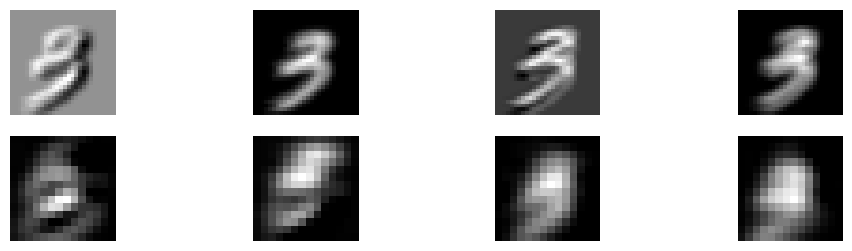

Epoch:11/15
Train error: 0.03397618401050568
Train accuracy: 78.4%
Test error: 0.033609974384307864
Test accuracy: 82.0%


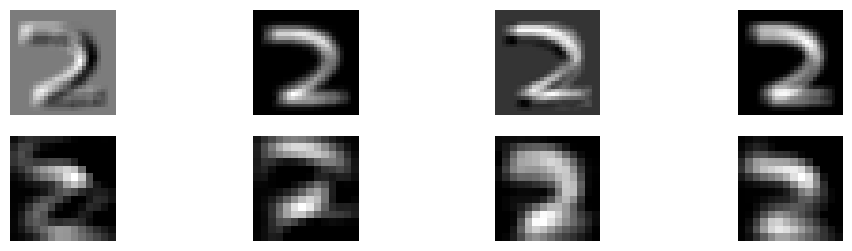

Epoch:12/15
Train error: 0.03345430815219879
Train accuracy: 81.3%
Test error: 0.03293035626411438
Test accuracy: 86.0%


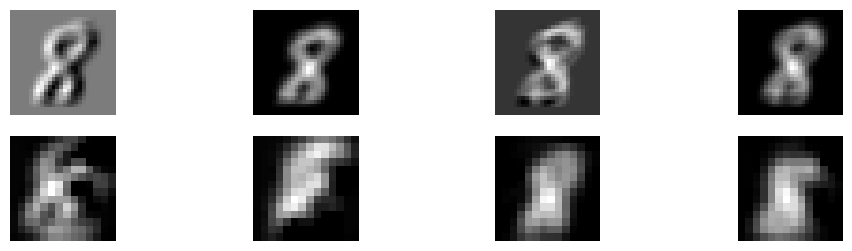

Epoch:13/15
Train error: 0.03318915605545044
Train accuracy: 81.8%
Test error: 0.032700691223144535
Test accuracy: 86.0%


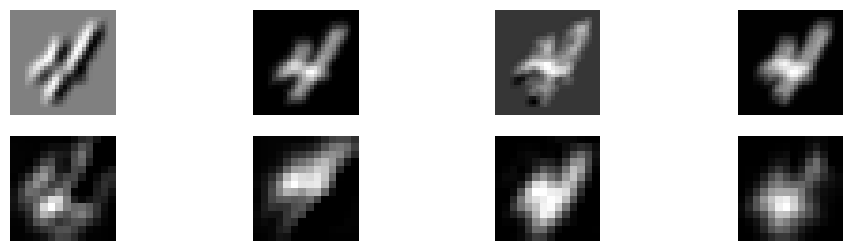

Epoch:14/15
Train error: 0.032924031257629396
Train accuracy: 83.1%
Test error: 0.03266514420509339
Test accuracy: 86.0%


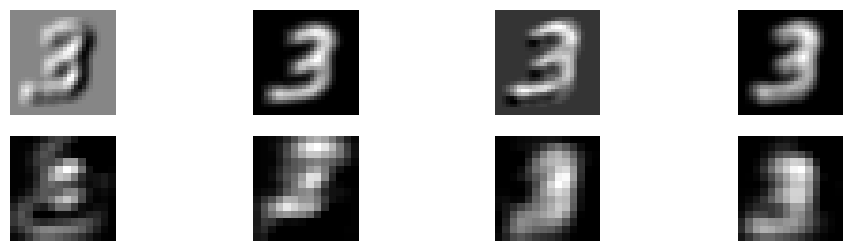

Epoch:15/15
Train error: 0.032992334961891176
Train accuracy: 82.69999999999999%
Test error: 0.03249235510826111
Test accuracy: 85.0%


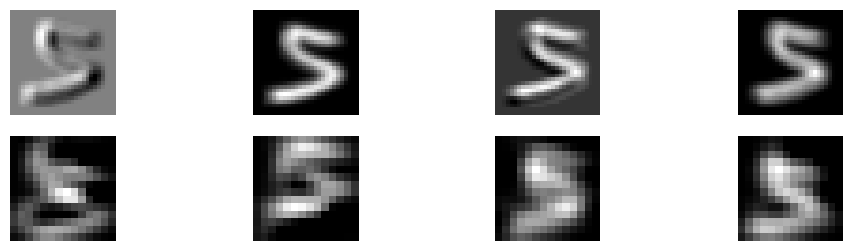

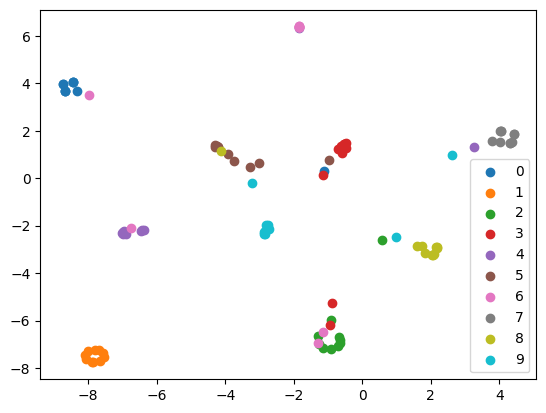

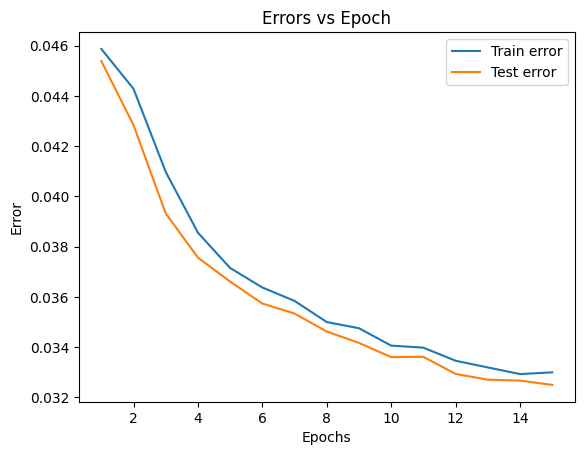

In [35]:
network = Network_dropout(dr = 0.2)
train(15, train_data, test_data, 50, 'rmsprop', True)

Dropout rate = 0.5

Epoch:1/15
Train error: 0.04601412558555603
Train accuracy: 13.700000000000001%
Test error: 0.04594327926635742
Test accuracy: 25.0%


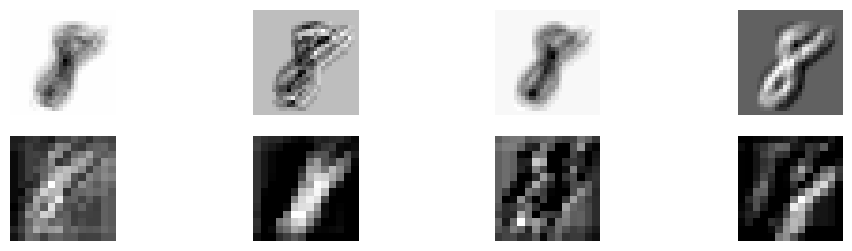

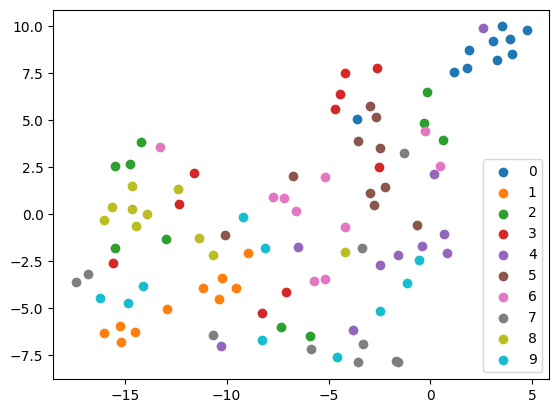

Epoch:2/15
Train error: 0.045693712711334225
Train accuracy: 23.200000000000003%
Test error: 0.04531200170516968
Test accuracy: 22.0%


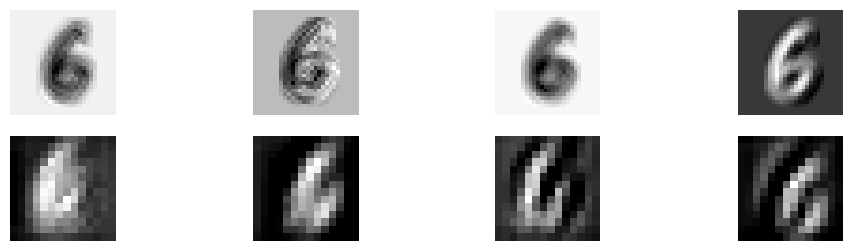

Epoch:3/15
Train error: 0.04478411746025086
Train accuracy: 24.2%
Test error: 0.04413218975067139
Test accuracy: 35.0%


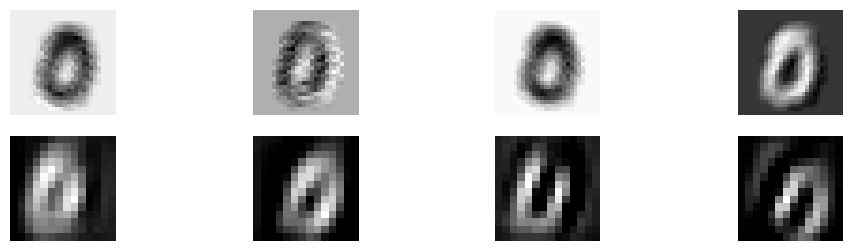

Epoch:4/15
Train error: 0.043493247509002686
Train accuracy: 34.2%
Test error: 0.042528753280639646
Test accuracy: 41.0%


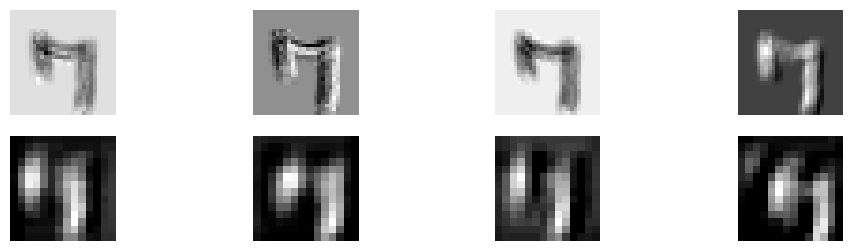

Epoch:5/15
Train error: 0.04213270878791809
Train accuracy: 40.5%
Test error: 0.04103717803955078
Test accuracy: 51.0%


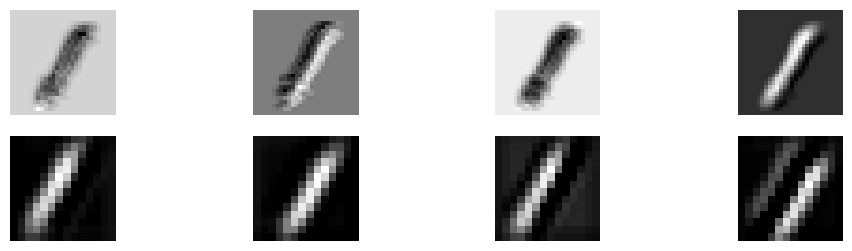

Epoch:6/15
Train error: 0.04106014609336853
Train accuracy: 44.9%
Test error: 0.03991639852523804
Test accuracy: 53.0%


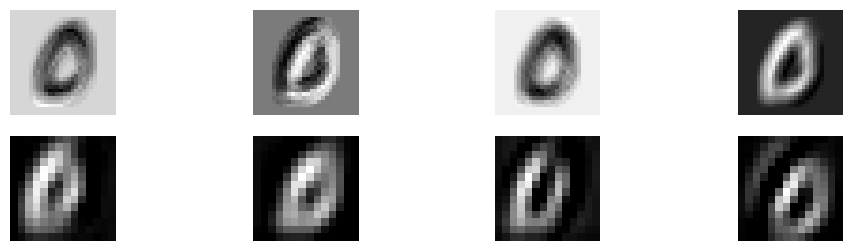

Epoch:7/15
Train error: 0.04032186269760132
Train accuracy: 48.0%
Test error: 0.038976629972457884
Test accuracy: 60.0%


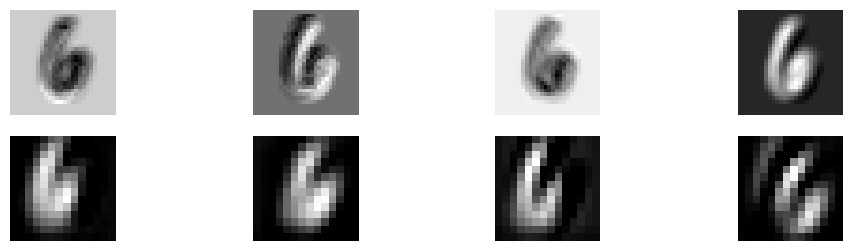

Epoch:8/15
Train error: 0.039454519152641296
Train accuracy: 52.6%
Test error: 0.03829253196716308
Test accuracy: 61.0%


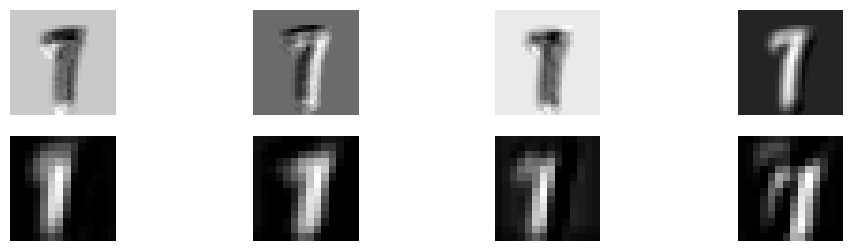

Epoch:9/15
Train error: 0.03881508481502533
Train accuracy: 55.00000000000001%
Test error: 0.03754566788673401
Test accuracy: 62.0%


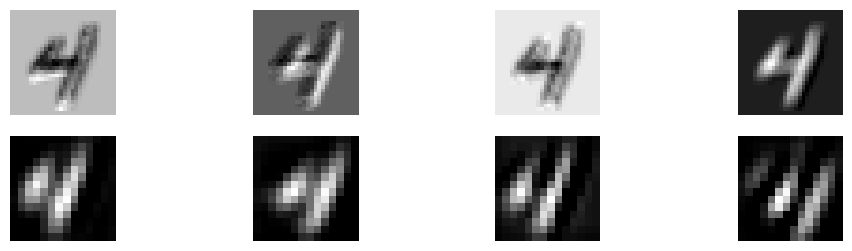

Epoch:10/15
Train error: 0.03799891400337219
Train accuracy: 60.099999999999994%
Test error: 0.036824508905410766
Test accuracy: 68.0%


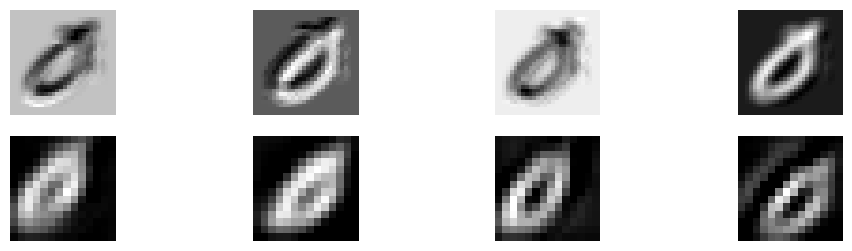

Epoch:11/15
Train error: 0.037772045850753784
Train accuracy: 60.4%
Test error: 0.0368262267112732
Test accuracy: 66.0%


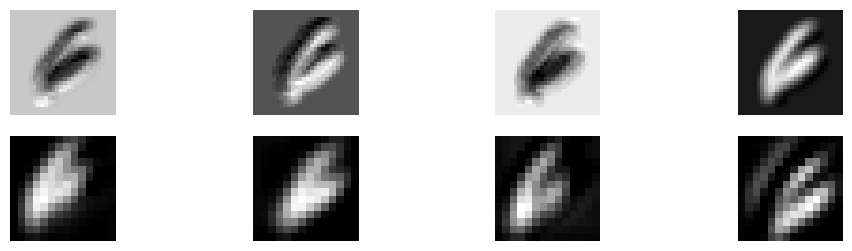

Epoch:12/15
Train error: 0.037051371932029724
Train accuracy: 63.3%
Test error: 0.03606126308441162
Test accuracy: 69.0%


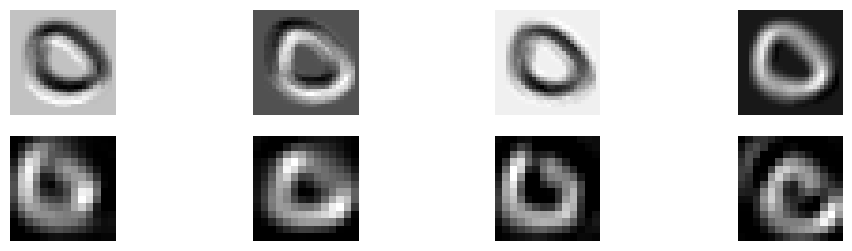

Epoch:13/15
Train error: 0.03701720476150513
Train accuracy: 64.1%
Test error: 0.03577545166015625
Test accuracy: 70.0%


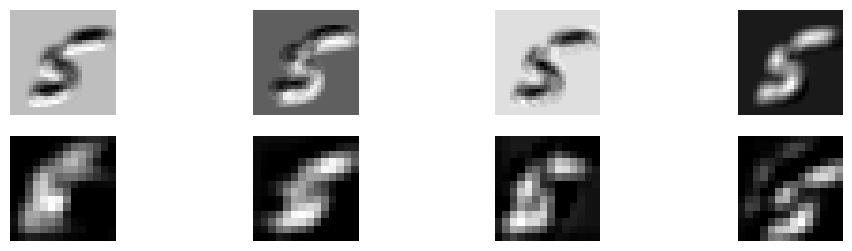

Epoch:14/15
Train error: 0.0366965856552124
Train accuracy: 64.8%
Test error: 0.035521130561828616
Test accuracy: 68.0%


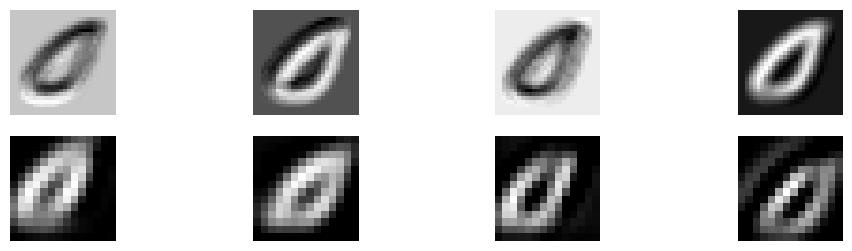

Epoch:15/15
Train error: 0.03634424912929535
Train accuracy: 65.9%
Test error: 0.03495453357696533
Test accuracy: 73.0%


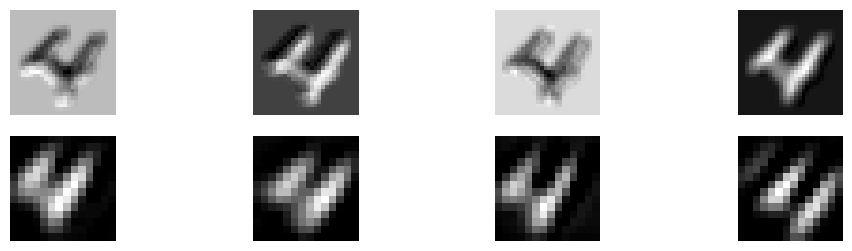

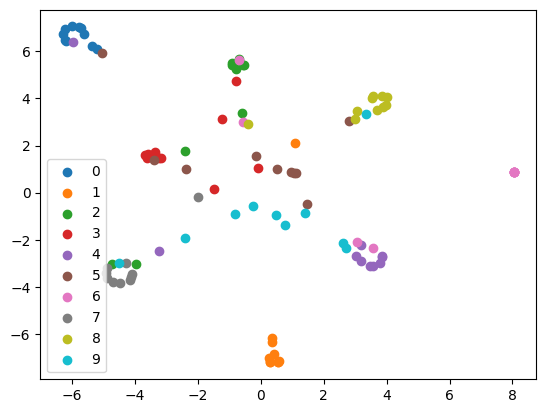

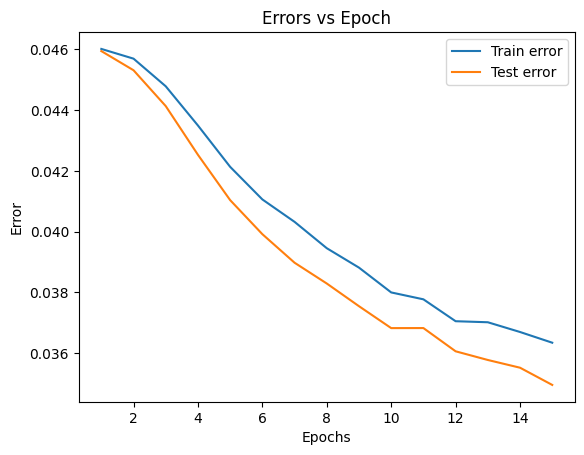

In [36]:
network = Network_dropout(dr=0.5)
train(15, train_data, test_data, 50, 'rmsprop', True)

Dropout rate = 0.8

Epoch:1/15
Train error: 0.04601510310173035
Train accuracy: 11.5%
Test error: 0.04593199253082275
Test accuracy: 25.0%


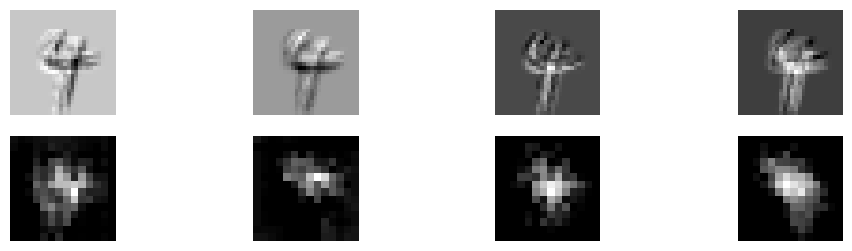

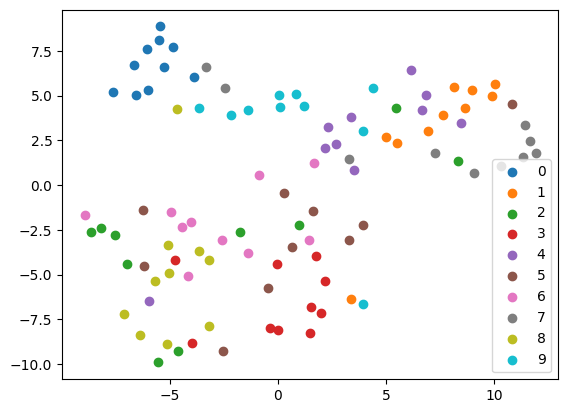

Epoch:2/15
Train error: 0.04581190586090088
Train accuracy: 12.6%
Test error: 0.04552547454833984
Test accuracy: 34.0%


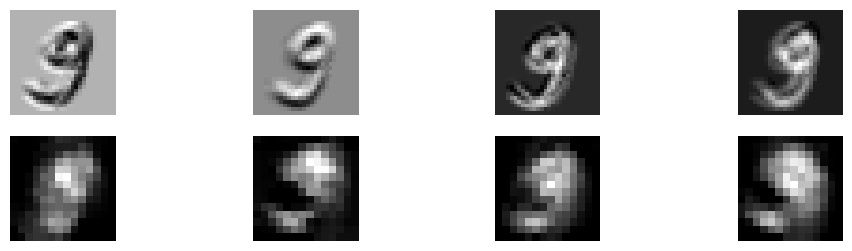

Epoch:3/15
Train error: 0.04543834400177002
Train accuracy: 16.3%
Test error: 0.04494008779525757
Test accuracy: 22.0%


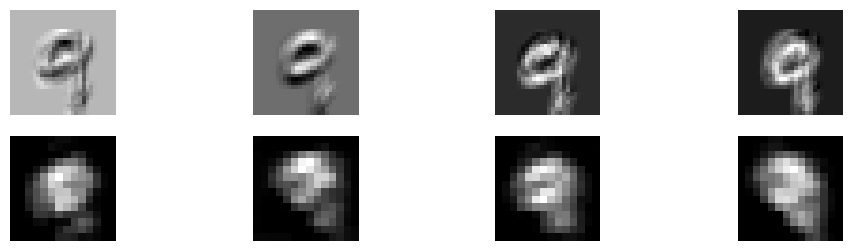

Epoch:4/15
Train error: 0.04483569860458374
Train accuracy: 20.200000000000003%
Test error: 0.04394402265548706
Test accuracy: 48.0%


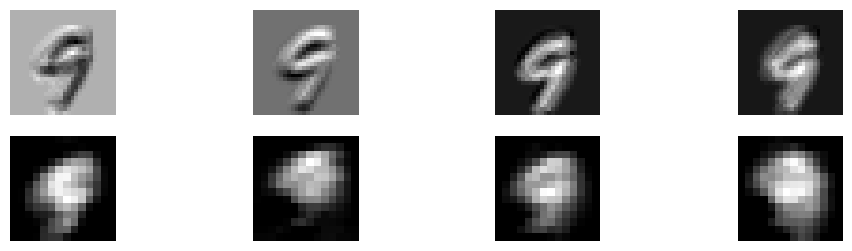

Epoch:5/15
Train error: 0.04407492280006409
Train accuracy: 26.8%
Test error: 0.0424691104888916
Test accuracy: 48.0%


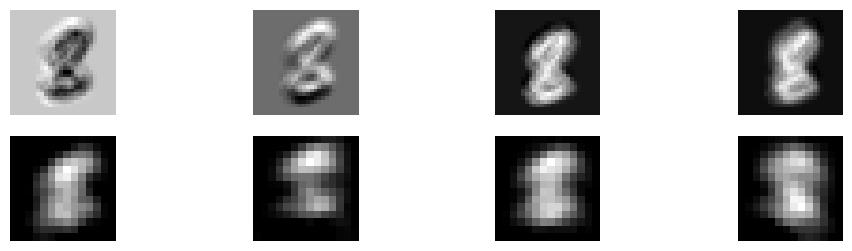

Epoch:6/15
Train error: 0.04332660698890686
Train accuracy: 29.2%
Test error: 0.041236495971679686
Test accuracy: 51.0%


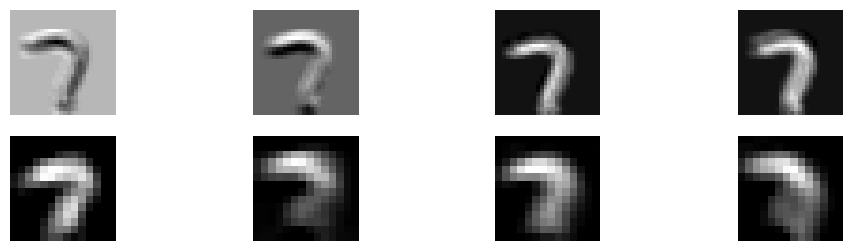

Epoch:7/15
Train error: 0.04278832483291626
Train accuracy: 32.4%
Test error: 0.04039949655532837
Test accuracy: 57.99999999999999%


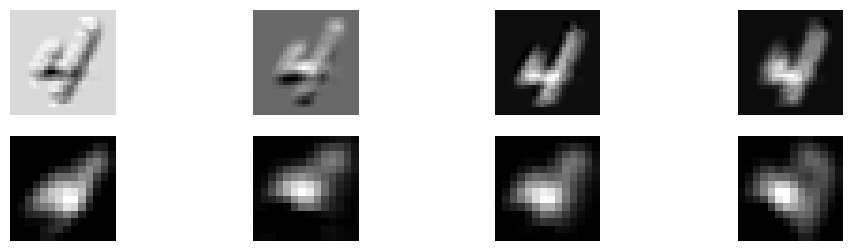

Epoch:8/15
Train error: 0.04231924486160278
Train accuracy: 35.5%
Test error: 0.039471009969711306
Test accuracy: 62.0%


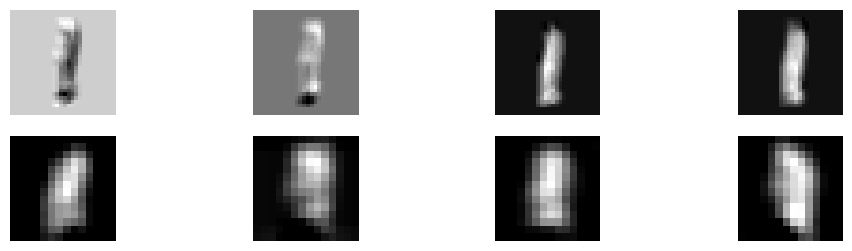

Epoch:9/15
Train error: 0.041575243592262265
Train accuracy: 40.1%
Test error: 0.03889098525047302
Test accuracy: 63.0%


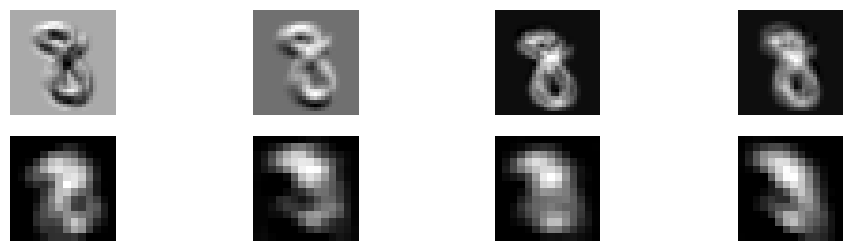

Epoch:10/15
Train error: 0.041502083420753476
Train accuracy: 39.0%
Test error: 0.03832743644714356
Test accuracy: 69.0%


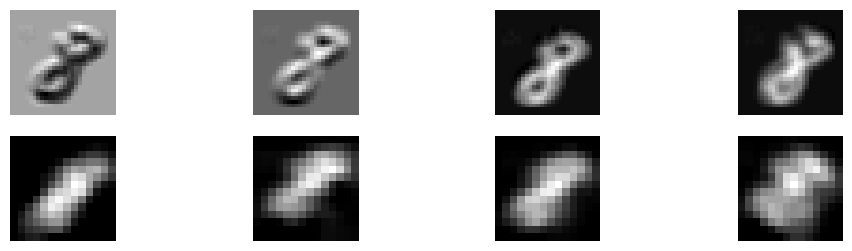

Epoch:11/15
Train error: 0.040746732115745546
Train accuracy: 45.1%
Test error: 0.037631828784942624
Test accuracy: 71.0%


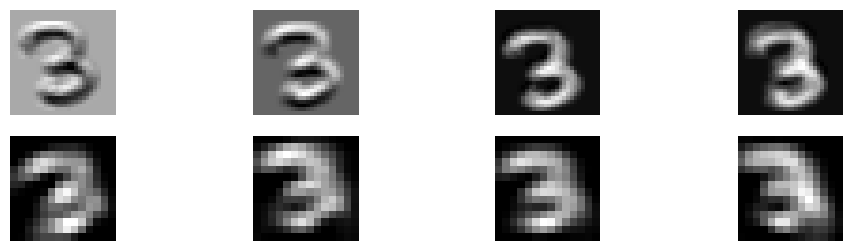

Epoch:12/15
Train error: 0.04056906199455261
Train accuracy: 44.0%
Test error: 0.037535394430160525
Test accuracy: 69.0%


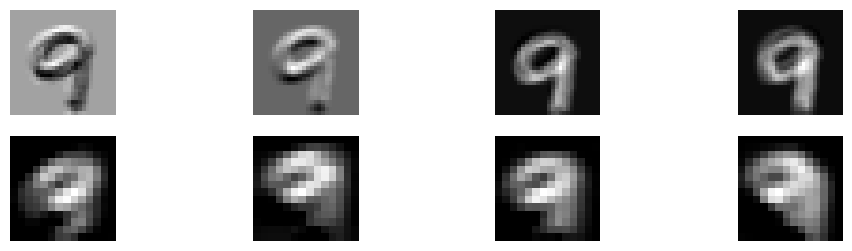

Epoch:13/15
Train error: 0.040192377090454104
Train accuracy: 45.6%
Test error: 0.036827707290649415
Test accuracy: 73.0%


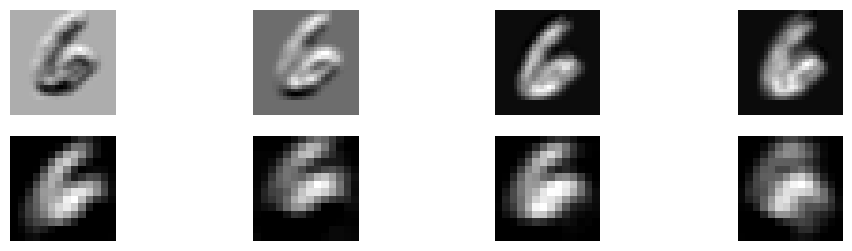

Epoch:14/15
Train error: 0.04022523546218872
Train accuracy: 46.300000000000004%
Test error: 0.03630407214164734
Test accuracy: 73.0%


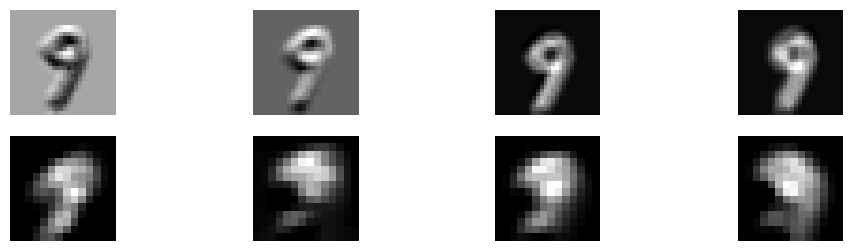

Epoch:15/15
Train error: 0.039822604298591614
Train accuracy: 47.699999999999996%
Test error: 0.03611577749252319
Test accuracy: 76.0%


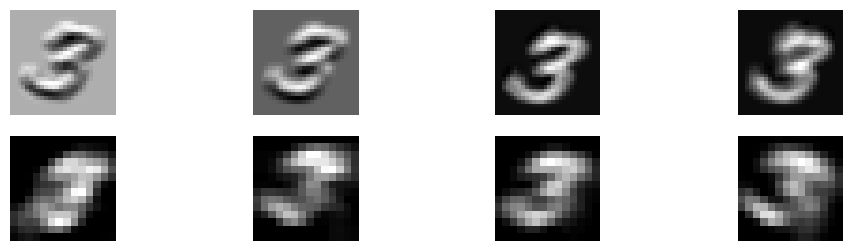

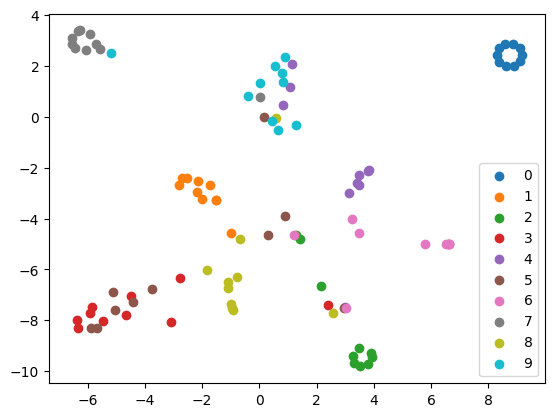

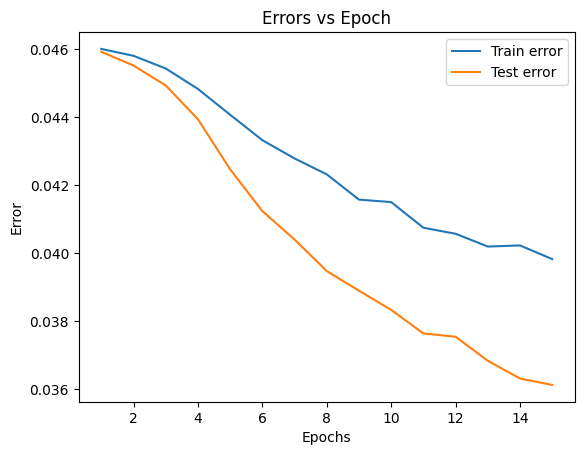

In [37]:
network = Network_dropout(0.8)
train(15, train_data, test_data, 50, 'rmsprop', True)

On comparing we can observe that the model without dropout converges at a lower pace compared to model with dropout.

There is a decrease in the training accuracy initially due to dropout.

Testing accuracy may improve or stabilize due to the regularization effect, preventing overfitting on the training set

In this case, dropout = 0.2 is well suited compared to other two as they regularise too much resulting in decrease of accuracy

6.

In [38]:
class Network_batchnorm(nn.Module):
  def __init__(self, dr):
    super(Network, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1, padding=2)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride=1, padding=2)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.flatten = nn.Identity()

    self.fc = nn.Sequential(
        nn.Linear(4 * 7 * 7, 49),
        nn.BatchNorm1d(49),
        nn.ReLU(),
        nn.Dropout(self.dr),
        nn.Linear(49, 10),
        nn.Softmax(dim=1)
    )

  def forward(self, x):

    x = F.relu(self.conv1(x))
    x = self.maxpool1(x)

    x = F.relu(self.conv2(x))
    x = self.maxpool2(x)

    x_flat = x.view(-1, 196)

    x_out = self.fc(x_flat)

    return x_out, x_flat

  def vis(self, x):
    slices = []
    x = self.conv1(x)
    slices.append(x)
    x = F.relu(x)
    x = self.maxpool1(x)
    x = F.relu(self.conv2(x))
    slices.append(x)
    return slices


Epoch:1/15
Train error: 0.04589811086654663
Train accuracy: 16.8%
Test error: 0.04545841932296753
Test accuracy: 34.0%


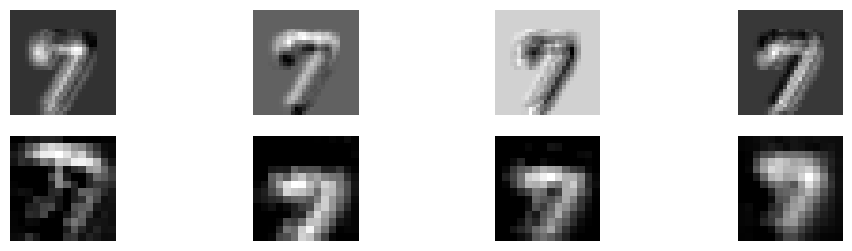

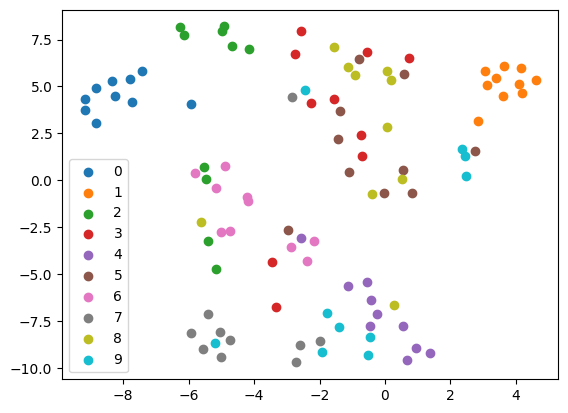

Epoch:2/15
Train error: 0.043977205753326414
Train accuracy: 38.1%
Test error: 0.0421675181388855
Test accuracy: 47.0%


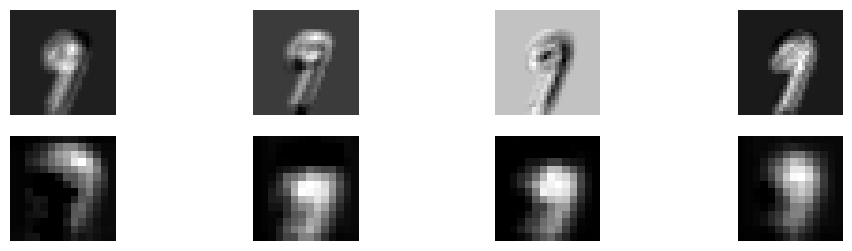

Epoch:3/15
Train error: 0.04079480028152466
Train accuracy: 51.300000000000004%
Test error: 0.03951326489448547
Test accuracy: 61.0%


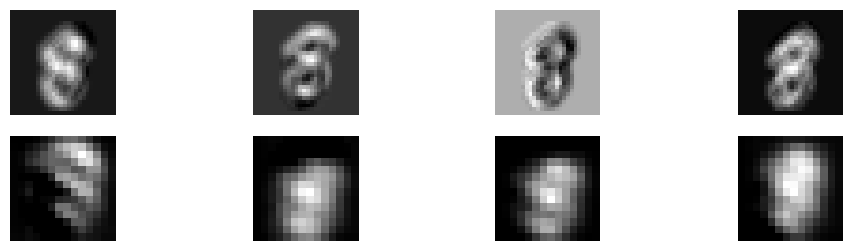

Epoch:4/15
Train error: 0.03869257771968842
Train accuracy: 60.5%
Test error: 0.037801722288131716
Test accuracy: 64.0%


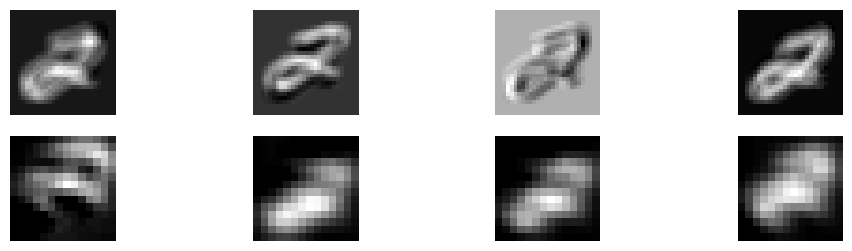

Epoch:5/15
Train error: 0.0373602237701416
Train accuracy: 63.4%
Test error: 0.03658096790313721
Test accuracy: 69.0%


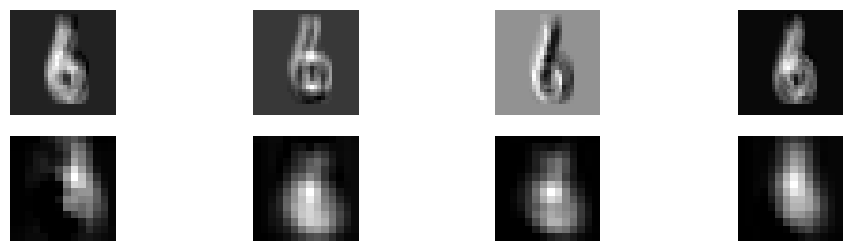

Epoch:6/15
Train error: 0.036503551006317136
Train accuracy: 66.0%
Test error: 0.035832905769348146
Test accuracy: 77.0%


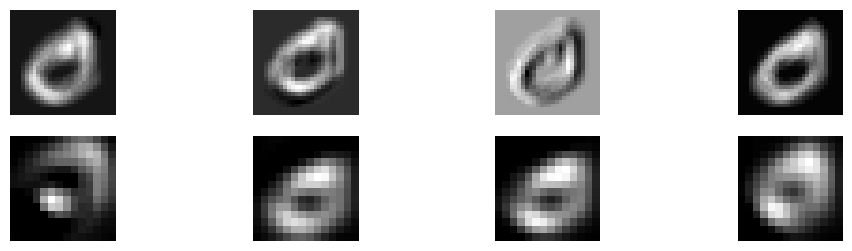

Epoch:7/15
Train error: 0.035760885119438174
Train accuracy: 70.1%
Test error: 0.03500884771347046
Test accuracy: 77.0%


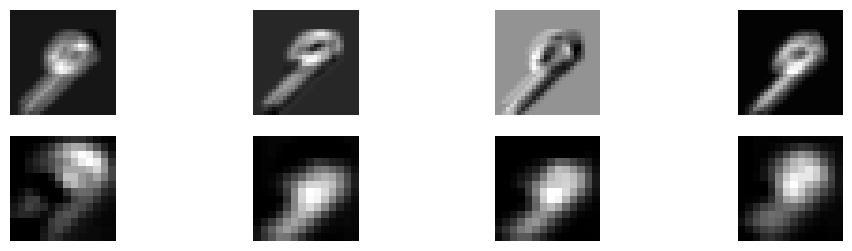

Epoch:8/15
Train error: 0.035065251588821414
Train accuracy: 73.6%
Test error: 0.034619078636169434
Test accuracy: 79.0%


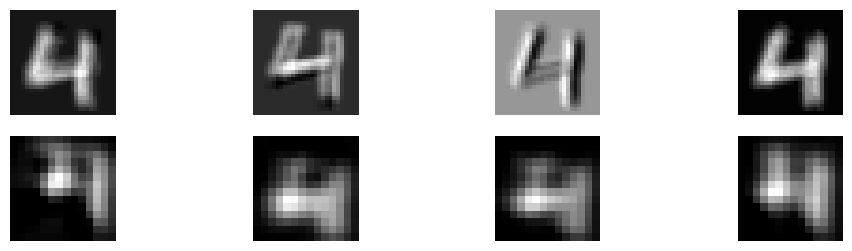

Epoch:9/15
Train error: 0.03436270332336426
Train accuracy: 76.5%
Test error: 0.03434149622917175
Test accuracy: 78.0%


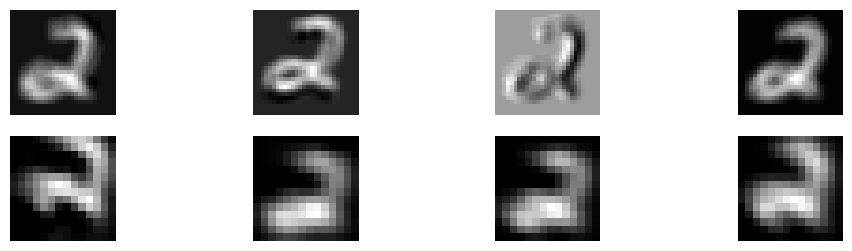

Epoch:10/15
Train error: 0.034173123836517334
Train accuracy: 76.9%
Test error: 0.03341157913208008
Test accuracy: 82.0%


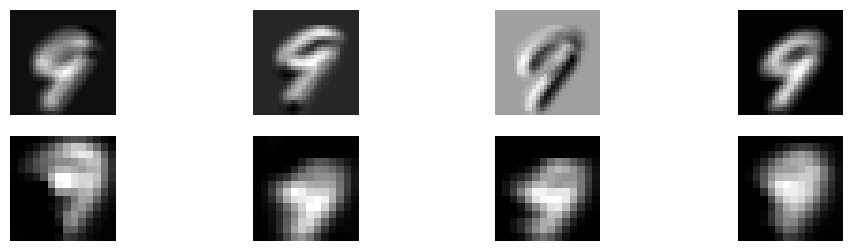

Epoch:11/15
Train error: 0.0338966703414917
Train accuracy: 79.0%
Test error: 0.03331986904144287
Test accuracy: 80.0%


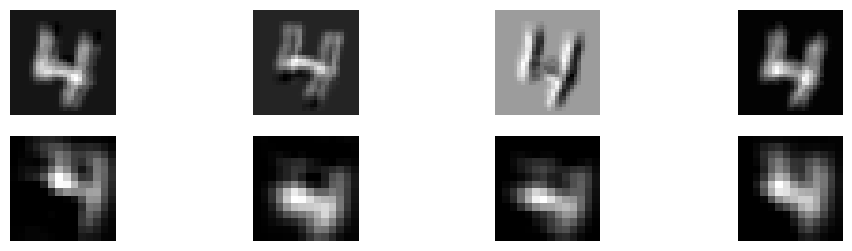

Epoch:12/15
Train error: 0.03345836126804352
Train accuracy: 80.9%
Test error: 0.03289577841758728
Test accuracy: 86.0%


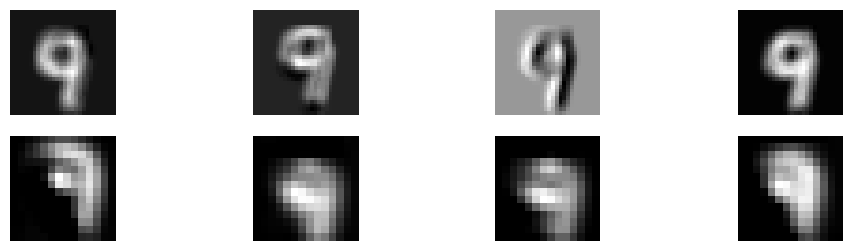

Epoch:13/15
Train error: 0.03329179871082306
Train accuracy: 82.1%
Test error: 0.03257276654243469
Test accuracy: 87.0%


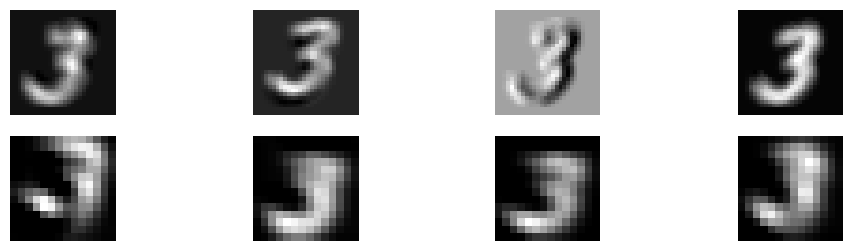

Epoch:14/15
Train error: 0.032849472641944884
Train accuracy: 84.0%
Test error: 0.03307941555976868
Test accuracy: 83.0%


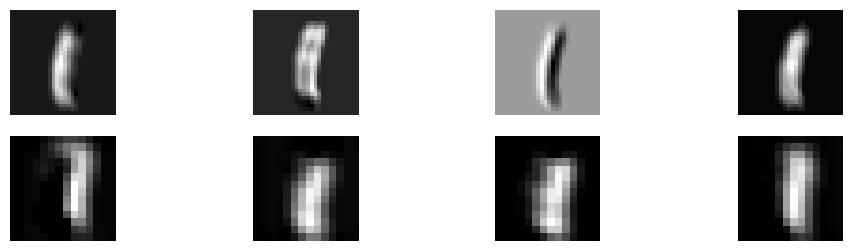

Epoch:15/15
Train error: 0.03292258024215698
Train accuracy: 83.2%
Test error: 0.03244543671607971
Test accuracy: 87.0%


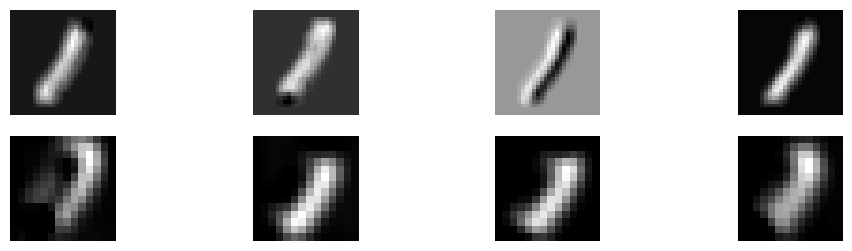

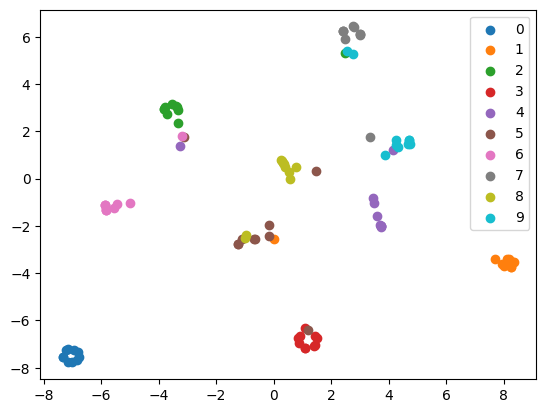

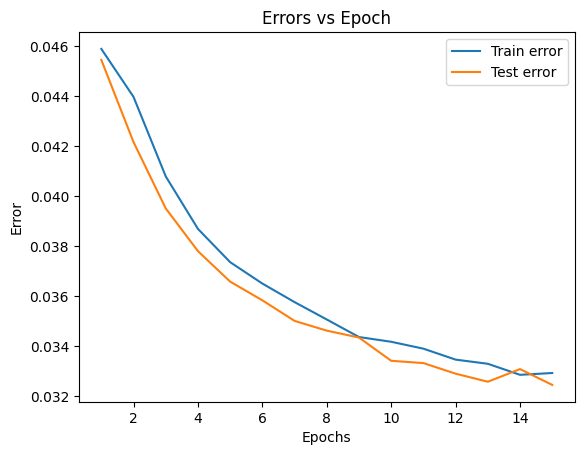

In [39]:
network = Network_dropout(0.2)
train(15, train_data, test_data, 50, 'rmsprop', True)

Dropout and batch normalization leads to well generalized model which makes it better than vanilla implementation model and model with dropout.


There is a slight increase in convergence rate during training as it helps with internal covariate shift problem.

There is an increase in the testing accuracy due to batch normalisation.